In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from matplotlib.dates import *
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
import pytz as pytz
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import modules.thermolib as thermo
import modules.DSDlib as dsd
import modules.disdrometer_module as dis
import modules.radarmodule as radar
import modules.simulator as sim
import modules.plotmodule as pm
from modules.datahandler import getDataHandler
#import obanmodule as oban
import pandas as pd
import glob
import pyart as pyart
from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from metpy.plots import ctables
%matplotlib notebook
%load_ext autoreload
%autoreload 2


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis

# Could be one of '060509', '060709', or '060909', currently
casedate = '060509'

# List of field names to read
fieldnames = ['dBZ']
# Requested elevation angle
el_req = 0.5

# Note: the feature_* parameters in the dictionary are manually derived locations (radar relative) of some feature
# in the radar data that are used to compute the storm motion. In the 060509 case, I'm using the location of the
# inflow notch (similar to French et al. 2012). Other features may be more appropriate for the other cases.

init_radar_dict = {'060509': {'feature_start_loc': (30., 57.), 'feature_end_loc': (58., 53.),
                         'feature_start_time': datetime(2009, 6, 5, 21, 57, 43),
                         'feature_end_time': datetime(2009, 6, 5, 22, 43, 29),
                         'sweeptime_ref': datetime(2009, 6, 5, 22, 2, 18),
                         'radardir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad',
                         'fieldnames': fieldnames,
                         'el_req': el_req,
                         'radstarttime': '20090605215500',
                         'radstoptime': '20090605224500',
                         'fieldnames': ['dBZ'],
                         'el_req': 0.5},
              '060709': {'feature_start_loc': (-94., 138.), 'feature_end_loc': (-75., 132.),
                         'feature_start_time': datetime(2009, 6, 7, 23, 16, 34),
                         'feature_end_time': datetime(2009, 6, 7, 23, 43, 54),
                         'sweeptime_ref': datetime(2009, 6, 7, 23, 34, 32),
                         'radardir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060709/nexrad',
                         'fieldnames': fieldnames,
                         'el_req': el_req,
                         'radstarttime': '20090607231500',
                         'radstoptime': '20090608001000',
                         'fieldnames': ['dBZ'],
                         'el_req': 0.5},
              '060909': {'feature_start_loc': (16., -5.), 'feature_end_loc': (37., -8.),
                         'feature_start_time': datetime(2009, 6, 9, 23, 16, 20),
                         'feature_end_time': datetime(2009, 6, 9, 23, 39, 31),
                         'sweeptime_ref': datetime(2009, 6, 9, 23, 29, 59),
                         'radardir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad',
                         'fieldnames': fieldnames,
                         'el_req': el_req,
                         'radstarttime': '20090609231500',
                         'radstoptime': '20090610000000',
                         'fieldnames': ['dBZ'],
                         'el_req': 0.5}}

init_dis_dict = {'060509': {'dis_dir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/dsdprobes/',
                       'dis_types': ['CU', 'CU', 'NV2', 'NV2'],
                       'dis_names': ['CU1', 'CU2', 'P1', 'P2'],
                       'disfilenames': ['20090605_PA01.txt', 
                                        '20090605_PA02.txt', 
                                        '2009_06_05_D1_DIS_P1.nc', 
                                        '2009_06_05_D1_DIS_P2.nc'],
                       'convfilenames': ['20090605_CU1.dat', 
                                         '20090605_CU2.dat', 
                                         '2009_06_05_D1_TRP_P1.nc', 
                                         '2009_06_05_D1_TRP_P2.nc'],
                       'starttimes': ['20090605215500', '20090605213500', '20090605215500', '20090605215500'],
                       'stoptimes': ['20090605224500', '20090605224500', '20090605224500', '20090605224500']},
            '060709': {'dis_dir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060709/dsdprobes/',
                       'dis_types': ['CU', 'NV2', 'NV2'],
                       'dis_names': ['CU2', 'P1', 'P2'],
                       'disfilenames': ['20090607_PA02.txt', 
                                        '2009_06_07_D1_DIS_P1.nc', 
                                        '2009_06_07_D1_DIS_P2.nc'],
                       'convfilenames': ['20090607_CU2.dat', 
                                         '2009_06_07_D1_TRP_P1.nc', 
                                         '2009_06_07_D1_TRP_P2.nc'],
                       'starttimes': ['20090607231700', '20090607233800', '20090607233000'],
                       'stoptimes': ['20090607232900', '20090608000400', '20090607235800']},
            '060909': {'dis_dir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/dsdprobes/',
                       'dis_types': ['CU', 'CU', 'NV2', 'NV2'],
                       'dis_names': ['CU1', 'CU2', 'P1', 'P2'],
                       'disfilenames': ['20090609_PA01.txt',
                                        '20090609_PA02.txt', 
                                        '2009_06_09_D1_DIS_P1.nc', 
                                        '2009_06_09_D1_DIS_P2.nc'],
                       'convfilenames': ['20090609_CU1.dat',
                                         '20090609_CU2.dat', 
                                         '2009_06_09_D1_TRP_P1.nc', 
                                         '2009_06_09_D1_TRP_P2.nc'],
                       'starttimes': ['20090609232500', '20090609232800', '20090609232300', '20090609233000'],
                       'stoptimes': ['20090609234600', '20090609234500', '20090609234800', '20090609234300']}}

init_model_dict = {'060509': {'runname': 'jun05ZVDH3MCCN1imlt2_mod_nz61', 'modeltimesec_ref': 9960., 'probe_ref': 'P2', 
                         'ref_coords': (39500., 54500.), 'microphys': 'ZVD', 'model_dt': 120., 'multitime': False, 
                         'dirname': '/Volumes/depot/dawson29/data/VORTEX2/V2_disdrometer/simulations/COMMAS/060509/250m/',
                         'model_times': np.arange(7200., 10800.+120., 120.), 'composite': True,
                         'tracking_var': 'w', 'ref_coords_comp': (500., 500.)},
              '060709': {'runname': 'jun07ZVDH3MCCN1imlt2_nz61', 'modeltimesec_ref': 7080., 'probe_ref': 'P2', 
                         'ref_coords': (37500., 57500.), 'microphys': 'ZVD', 'model_dt': 120.,
                         'dirname': '/Volumes/scr_fast/Projects/VORTEX2/V2_disdrometer/simulations/COMMAS/060709/1km/',
                         'model_times': np.arange(7200., 10800.+120., 120.), 'composite': True,
                         'tracking_var': 'w', 'ref_coords_comp': (1500., 1500.)},
              '060909': {'runname': 'jun09ZVDH3MCCN1imlt2_nz61', 'modeltimesec_ref': 5760., 'probe_ref': 'P2', 
                         'ref_coords': (40500., 45500.), 'microphys': 'ZVD', 'model_dt': 120.,
                         'dirname': '/Volumes/scr_fast/Projects/VORTEX2/V2_disdrometer/simulations/COMMAS/060909/1km/',
                         'model_times': np.arange(3600., 7200.+120., 120.), 'composite': True,
                         'tracking_var': 'w', 'ref_coords_comp': (-1000., -1000.)}}

In [3]:
# Now go ahead and read in the sweeps for the desired case
radar_dict = sim.read_sweeps(casedate, init_radar_dict)

# Compute the storm motion
radar_dict = sim.compute_storm_motion(radar_dict)
print radar_dict[casedate]['feature_motion']

/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_ST

Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_215743_775_KCYS_v413_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.57128906
Time of sweep =  2009-06-05 21:57:43 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_220218_412_KCYS_v414_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-05 22:02:18 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_220652_743_KCYS_v415_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-05 22:06:52 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_221128_532_KCYS_v416_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-05 22:11:28 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_221602_969_KCYS_v417_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-05 22:16:02 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_222037_519_KCYS_v418_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.57128906
Time of sweep =  2009-06-05 22:20:37 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_222511_703_KCYS_v419_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-05 22:25:11 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_222946_072_KCYS_v420_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.5328369
Time of sweep =  2009-06-05 22:29:46 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_223420_461_KCYS_v421_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-05 22:34:20 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_223855_009_KCYS_v422_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.57128906
Time of sweep =  2009-06-05 22:38:55 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad/cfrad.20090605_224329_827_KCYS_v423_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-05 22:43:29 
Number of gates:  1832
Radar lat,lon,alt [41.15194320678711] [-104.80611419677734] [1882.0]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_ST

(10.196649672250546, -1.4566642388929352)


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_ST

Requested DSD interval: 60.0. Actual DSD interval: 60.0
Requested DSD interval: 60.0. Actual DSD interval: 60.0
Requested DSD interval: 60.0. Actual DSD interval: 60.0
Requested DSD interval: 60.0. Actual DSD interval: 60.0
46846.97792862546 55065.82066786219
44889.81243957477 63031.13130123799
lat =  41.6512107849
36818.375 55610.285
lat =  41.649936676
34375.45 55456.254
i, sweeptime =  2009-06-05 21:57:43


<IPython.core.display.Javascript object>


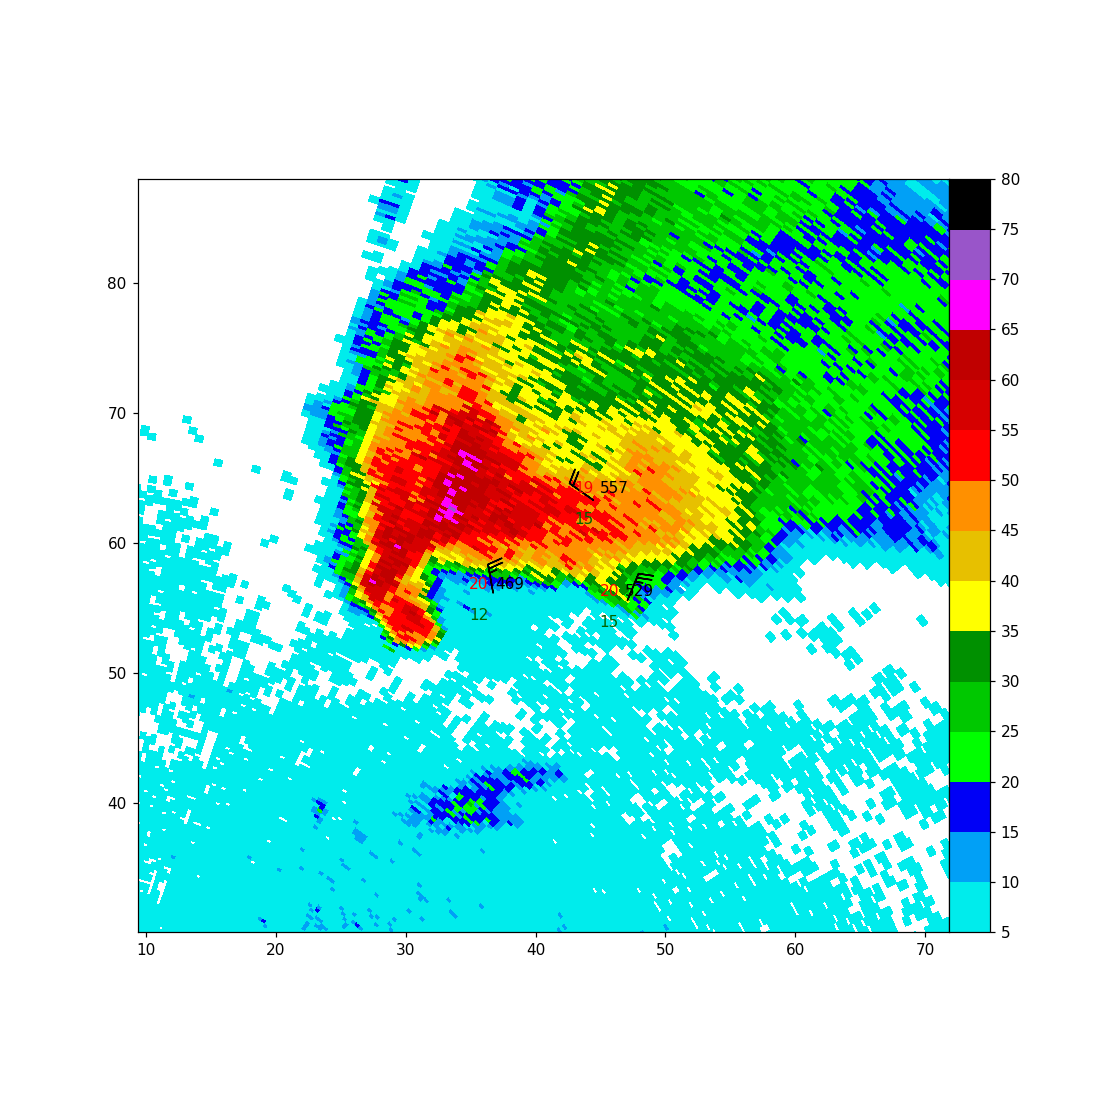

/Users/dawson29/MetPy/metpy/calc/basic.py:584: RuntimeWarning: All-NaN slice encountered
  if np.greater(np.nanmax(np.abs(value)), max_radians):


i, sweeptime =  2009-06-05 22:02:18


<IPython.core.display.Javascript object>


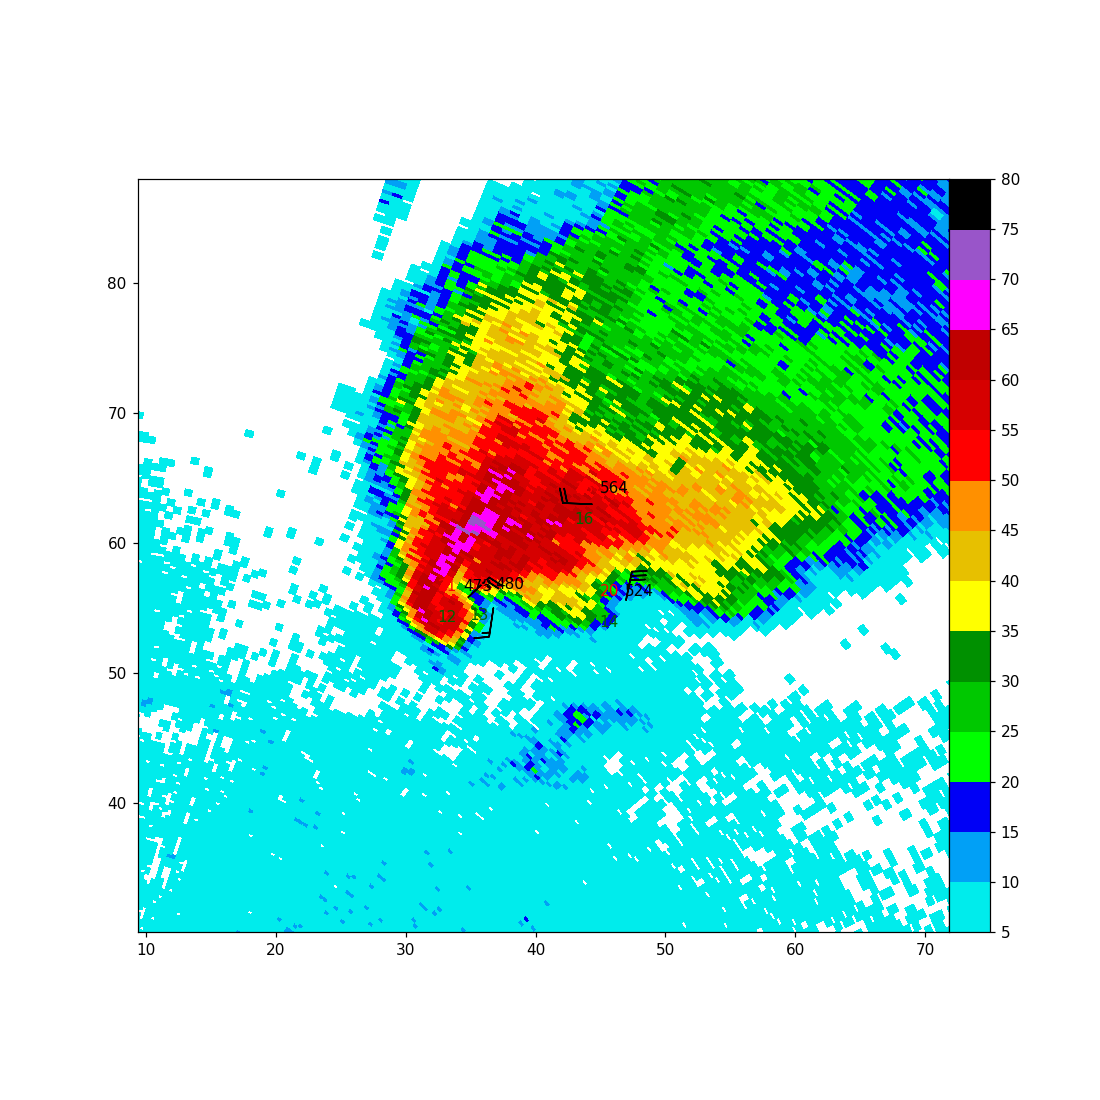

i, sweeptime =  2009-06-05 22:06:52


<IPython.core.display.Javascript object>


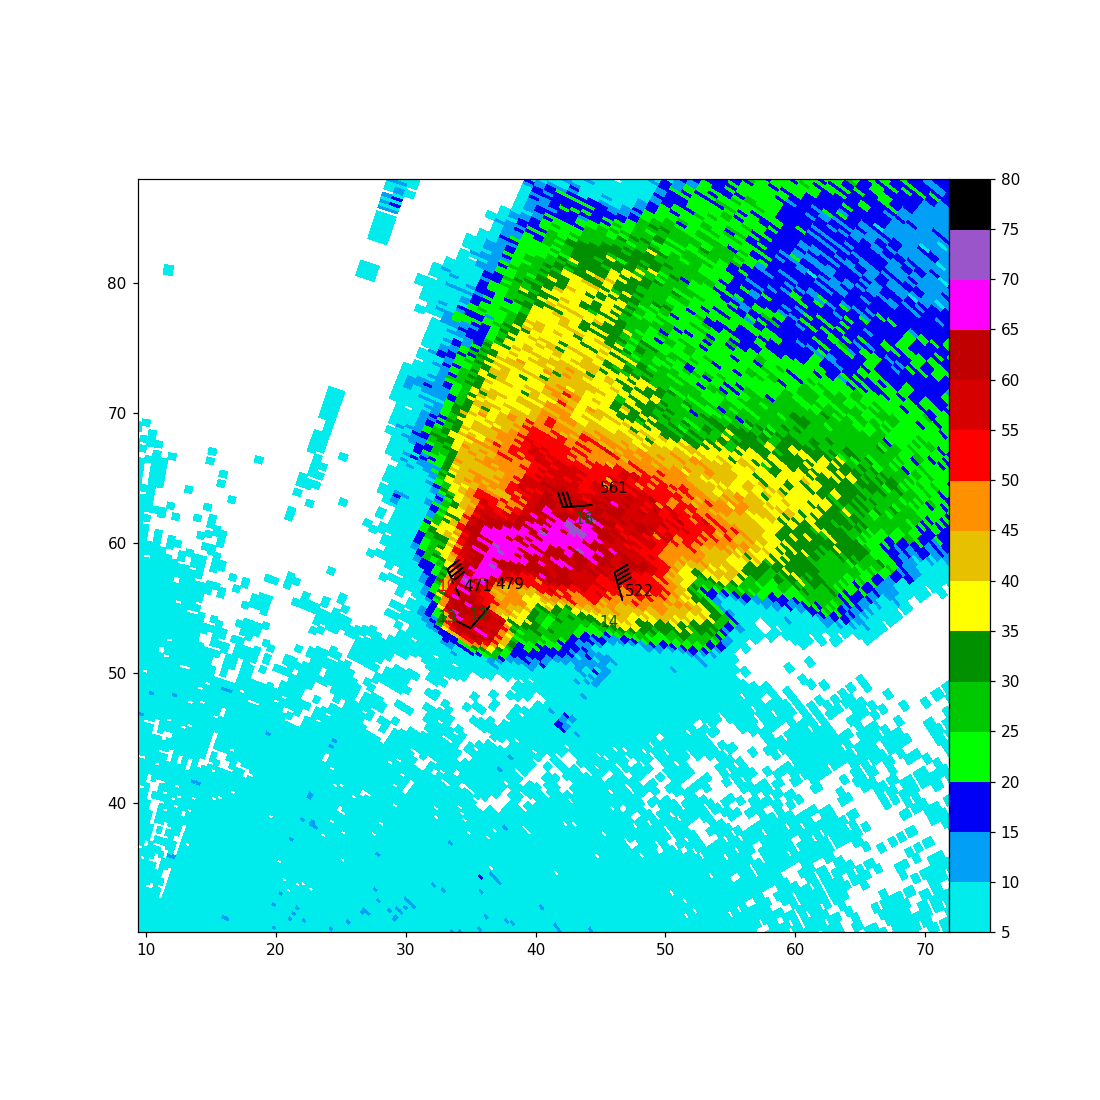

i, sweeptime =  2009-06-05 22:11:28


<IPython.core.display.Javascript object>


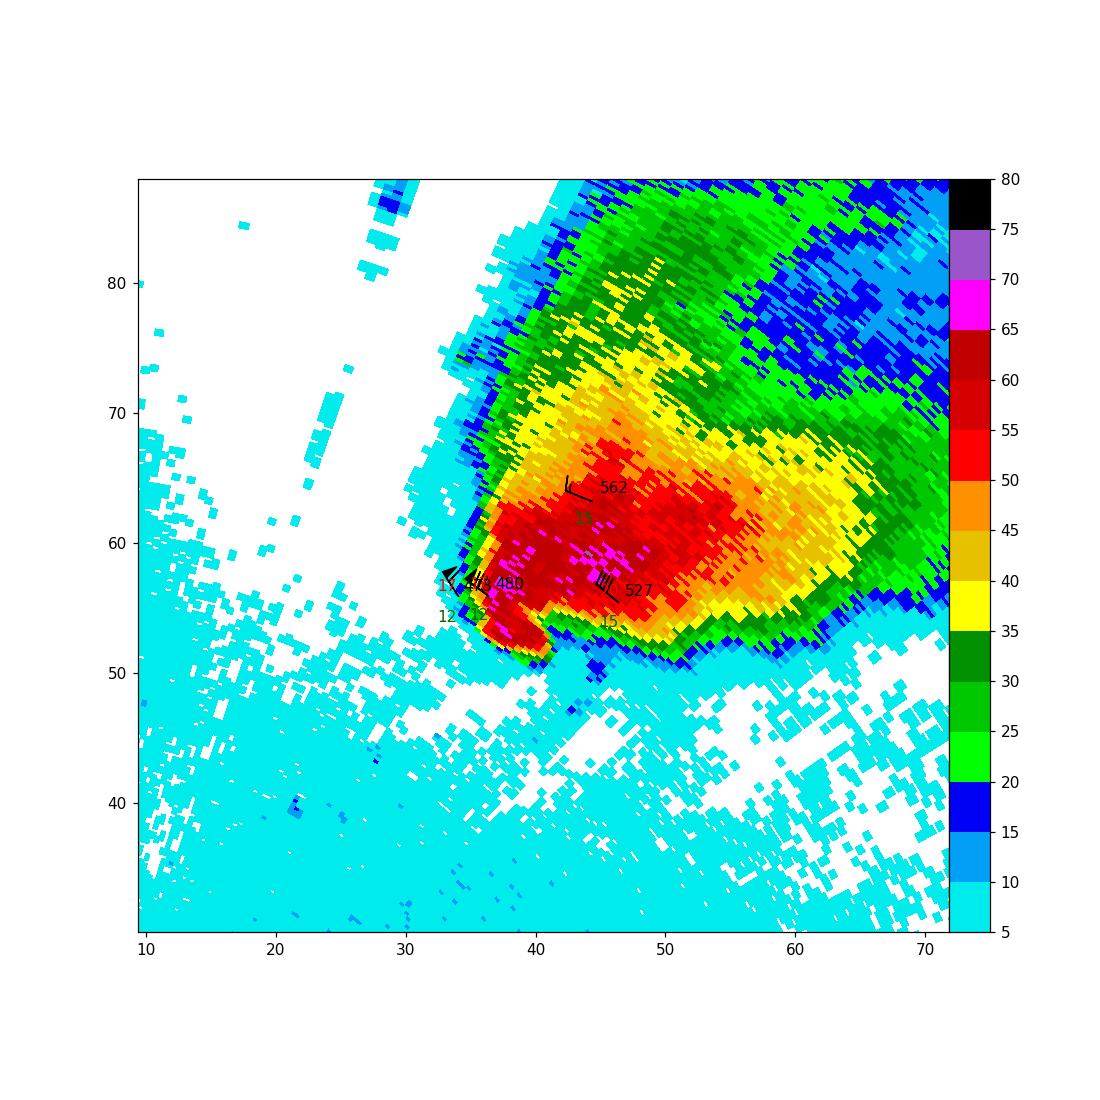

i, sweeptime =  2009-06-05 22:16:02


<IPython.core.display.Javascript object>


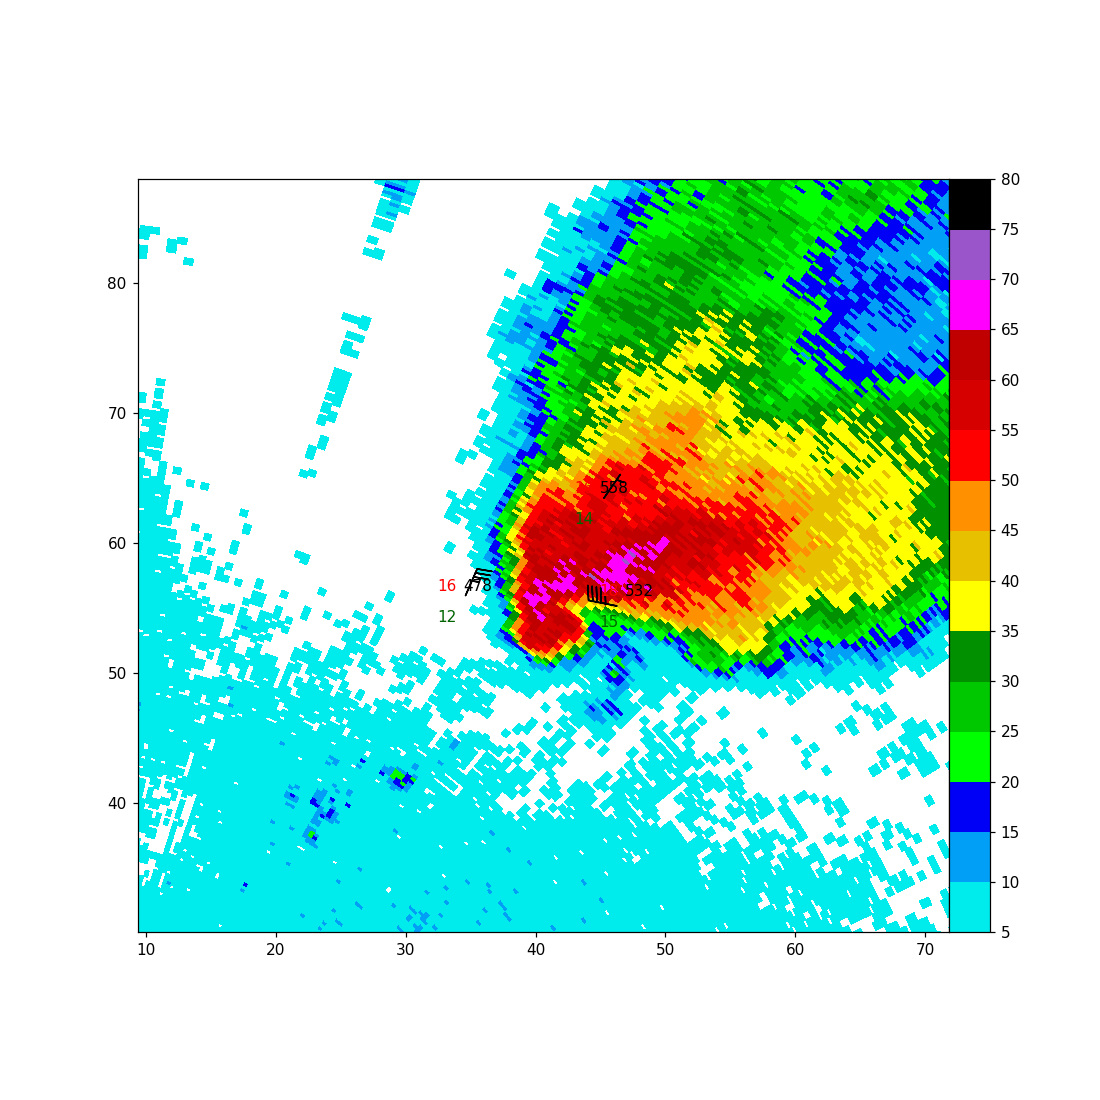

i, sweeptime =  2009-06-05 22:20:37


<IPython.core.display.Javascript object>


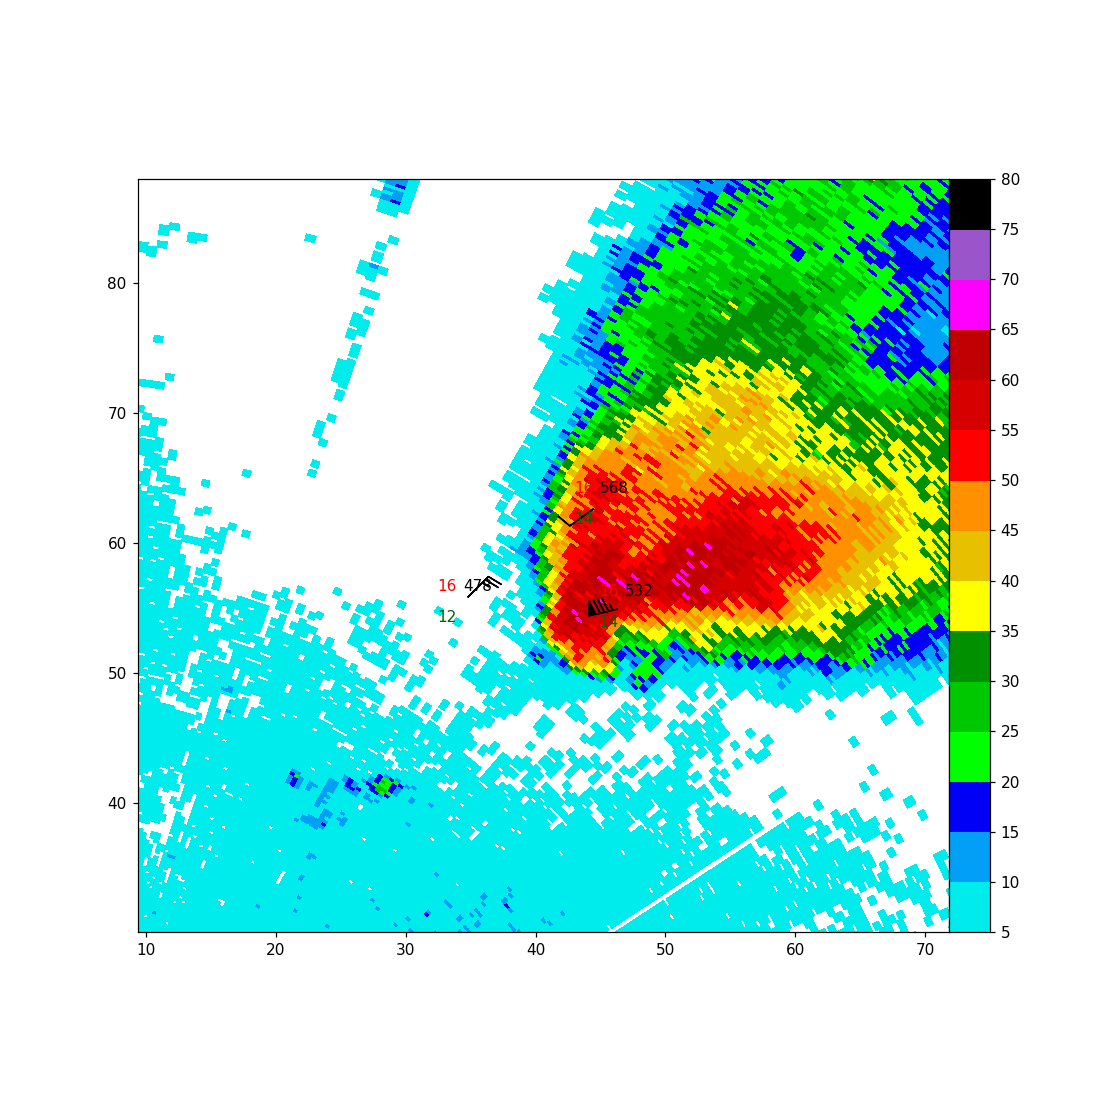

i, sweeptime =  2009-06-05 22:25:11


<IPython.core.display.Javascript object>


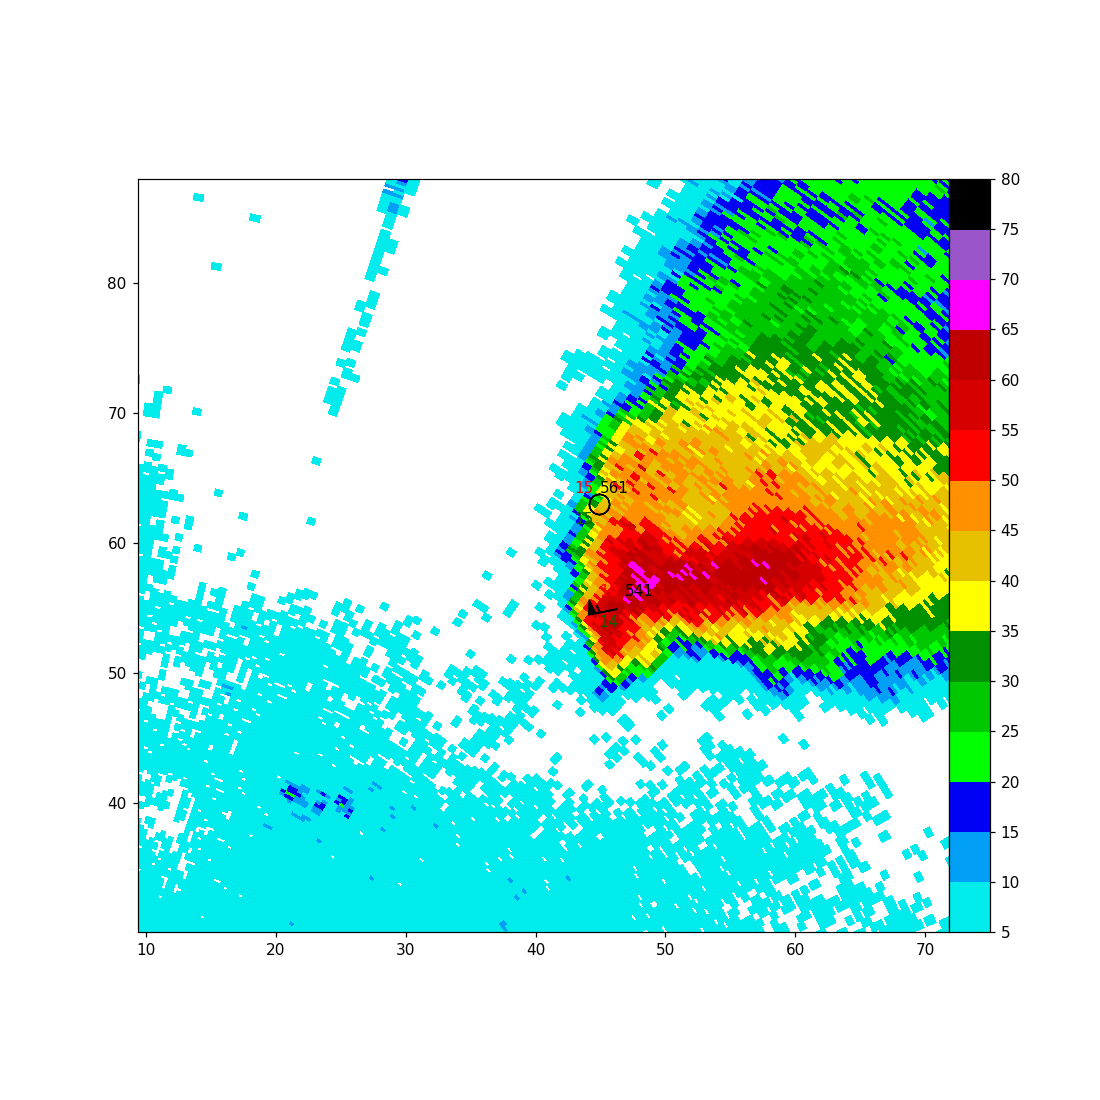

i, sweeptime =  2009-06-05 22:29:46


<IPython.core.display.Javascript object>


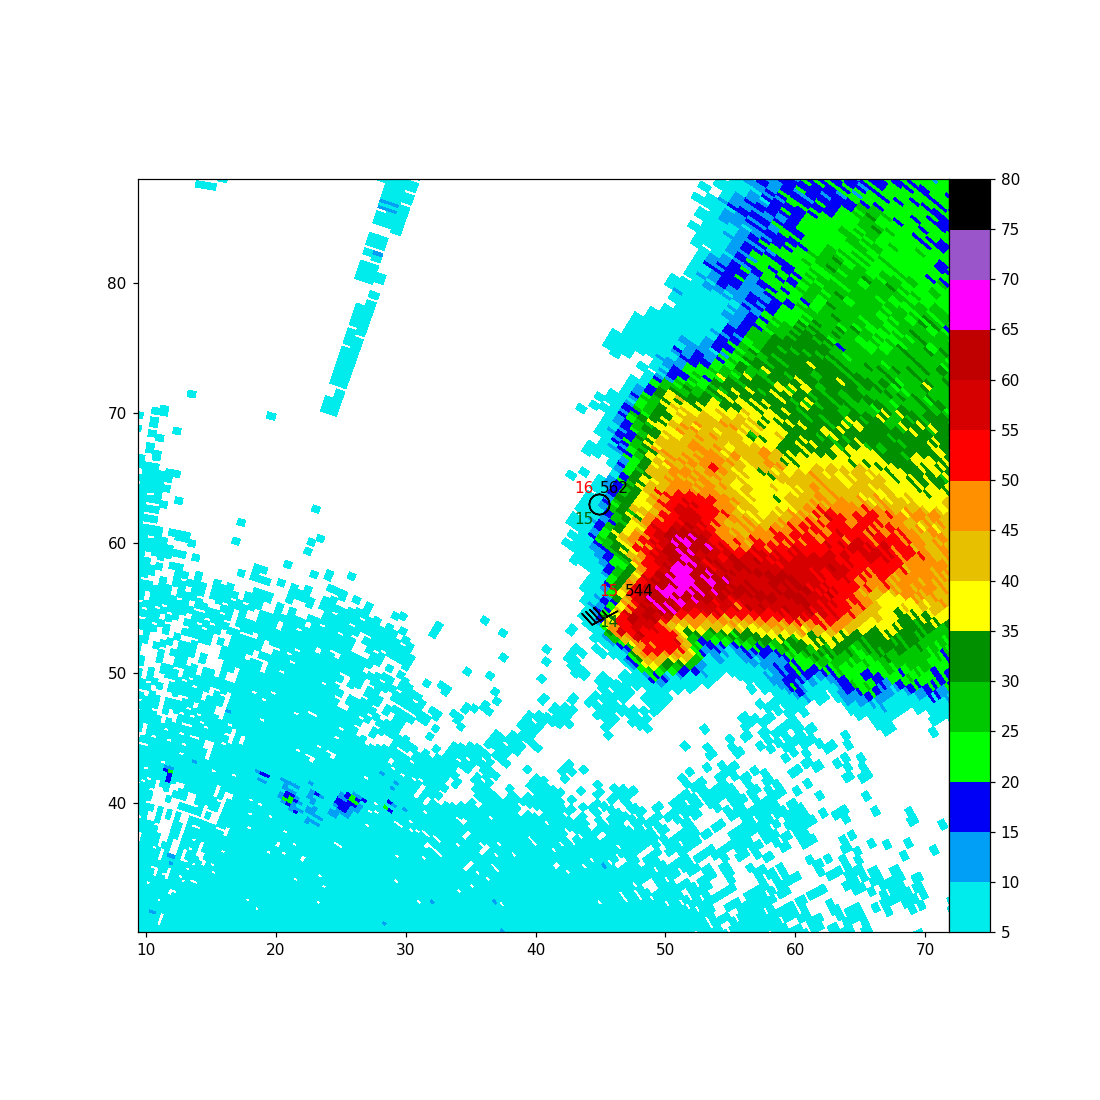

i, sweeptime =  2009-06-05 22:34:20


<IPython.core.display.Javascript object>


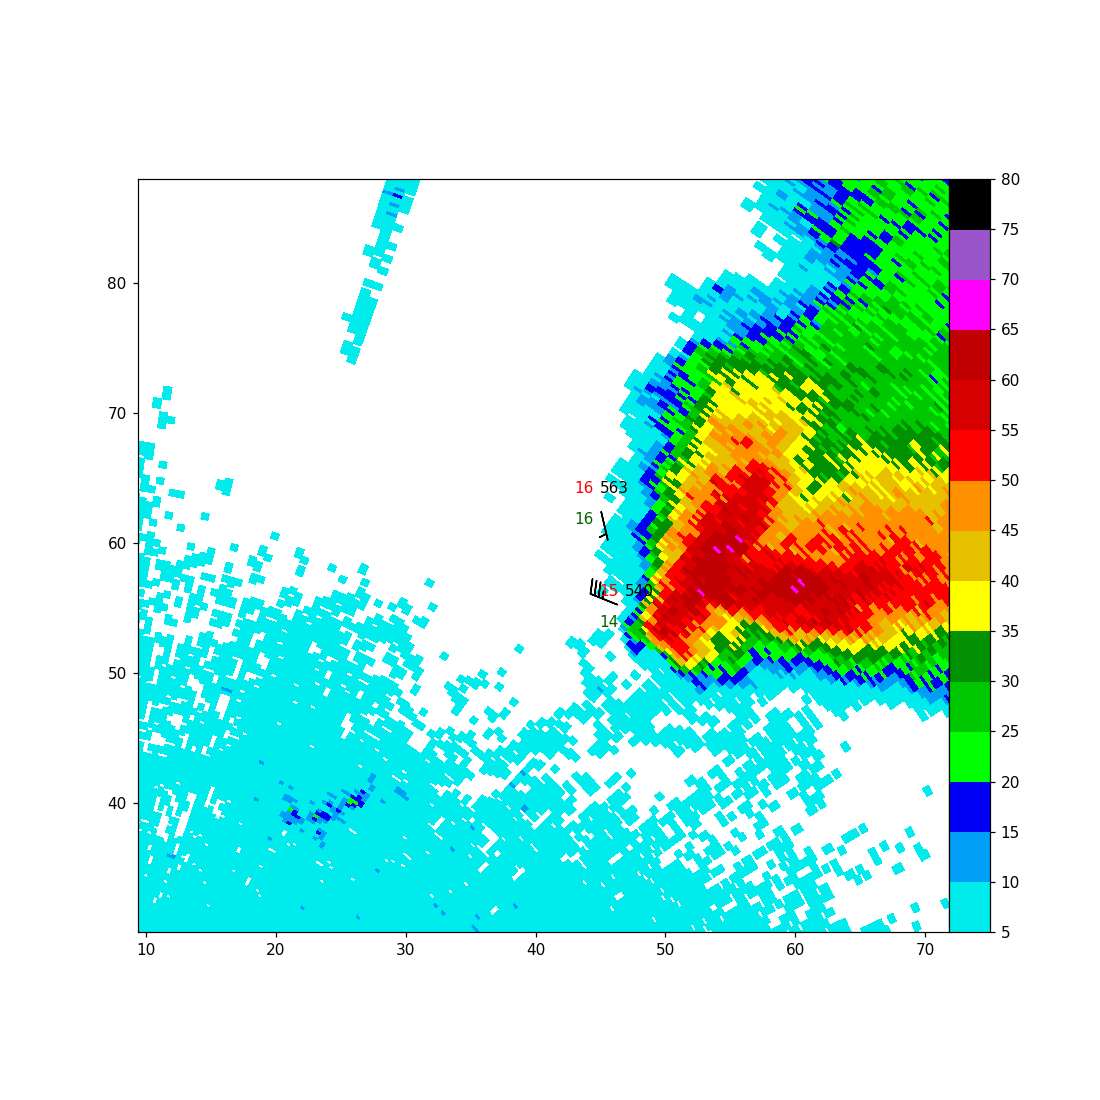

i, sweeptime =  2009-06-05 22:38:55


<IPython.core.display.Javascript object>


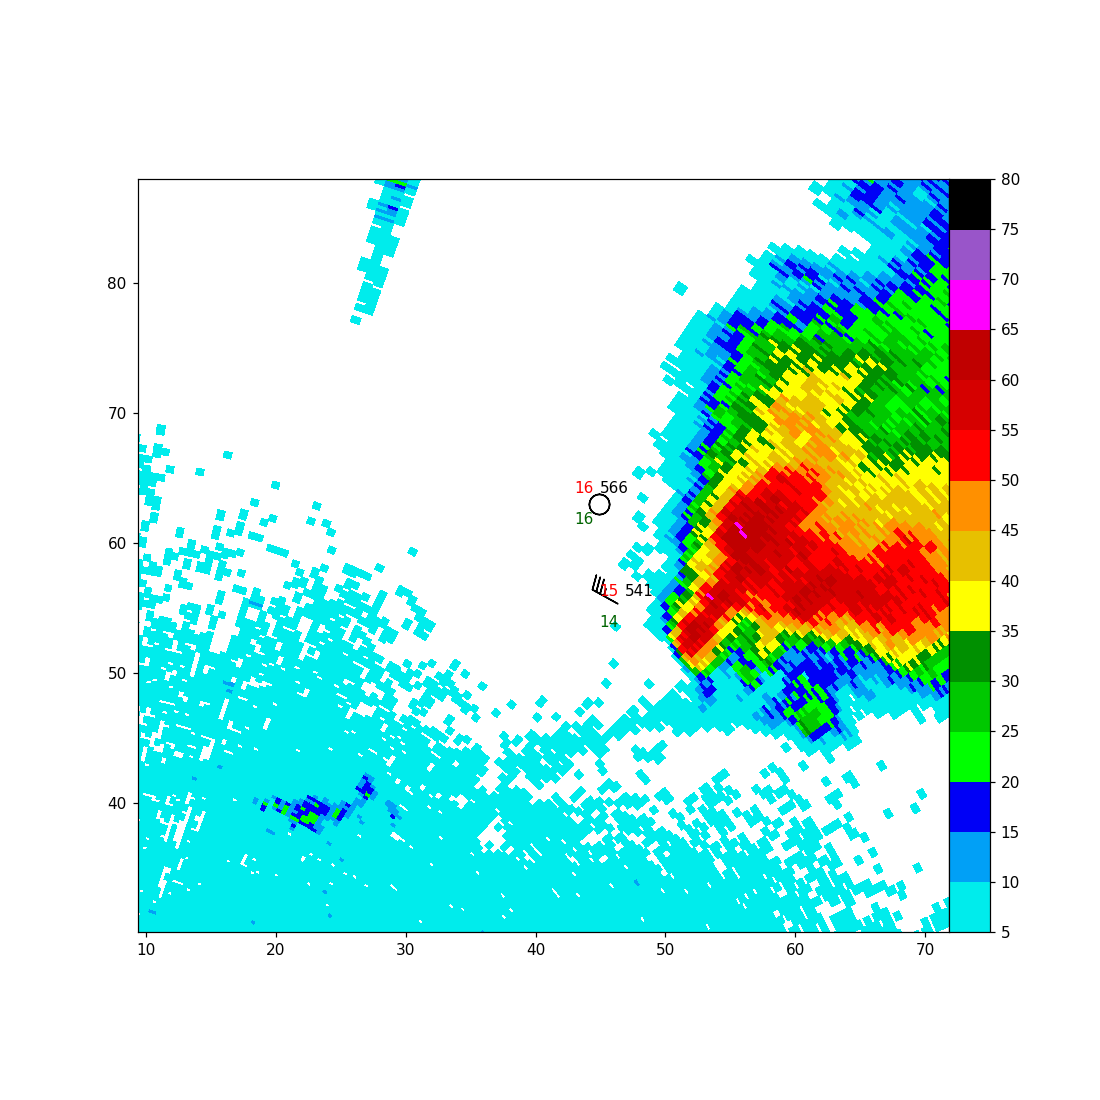

i, sweeptime =  2009-06-05 22:43:29


<IPython.core.display.Javascript object>


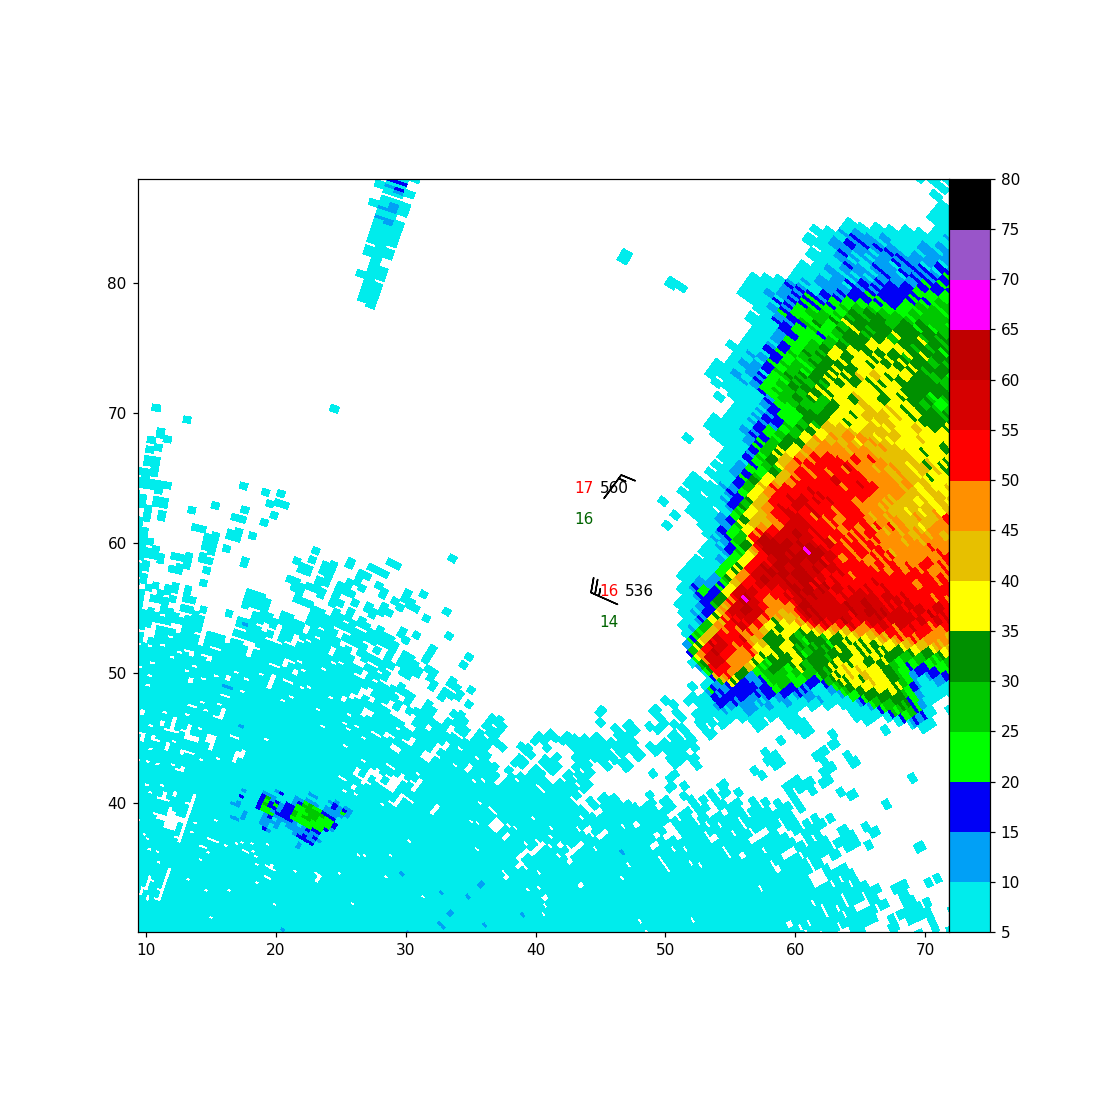

In [4]:
# Go ahead and read in the conventional data at the sweeptimes and plot them:
%matplotlib notebook
radlims = [0.0, 250000., 0., 360.]
plotlims = [-1, -1, -1, -1]
ovrmap = False
ovrdis = False
dis_name_list = None
dxy_list = None
fields_D_list = None
deg2rad = np.pi / 180.

# Read time series
dis_dict_at_radar = sim.read_convdata_at_sweeptimes(casedate, init_dis_dict, radar_dict)

# Find disdrometer lat/lons and convert them to cartesian coordinates relative to radar lat/lon

dis_dict = sim.get_dis_locs_relative_to_radar(casedate, init_dis_dict, radar_dict)

dxlist = [i[0] for i in dis_dict[casedate]['dradloclist']]
dylist = [i[1] for i in dis_dict[casedate]['dradloclist']]

# Set plotting limits to center on the disdrometer locations 
if plotlims[0] == -1:
    Dxmin = min(dxlist)
    Dxmax = max(dxlist)
    Dymin = min(dylist)
    Dymax = max(dylist)
    plotlims = [Dxmin - 25000., Dxmax + 25000., Dymin - 25000., Dymax + 25000.]

# Extract stuff from radar dictionary
sweeptimelist = radar_dict[casedate]['sweeptimelist']
radarsweeplist = radar_dict[casedate]['radarsweeplist']
outfieldnames = radar_dict[casedate]['outfieldnameslist'][0] # Just need first entry

# Extract stuff from disdrometer dictionary
templist = dis_dict_at_radar[casedate]['convdata_at_sweeptimes']['temp']
dewpointlist = dis_dict_at_radar[casedate]['convdata_at_sweeptimes']['dewpoint']
pressurelist = dis_dict_at_radar[casedate]['convdata_at_sweeptimes']['pressure']
windspdavgveclist = dis_dict_at_radar[casedate]['convdata_at_sweeptimes']['windspdavgvec']
winddiravgveclist = dis_dict_at_radar[casedate]['convdata_at_sweeptimes']['winddiravgvec']


for i, sweeptime in enumerate(sweeptimelist):
    print "i, sweeptime = ", sweeptime
    figlist, gridlist = radar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[i], ovrmap, 
                                              ovrdis, dis_name_list, dxy_list, fields_D_list)
    ax = gridlist[0][0]
    
    for j, Dx, Dy in zip(xrange(len(dxlist)), dxlist, dylist):
        stationplot = StationPlot(ax, [Dx], [Dy])
        stationplot.plot_parameter('NW', [templist[j][i]], color='red')
        stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
        stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
        u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
        stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))

    figlist[0].canvas.draw()
    figlist[0].set_size_inches(10., 10., forward = True)
    # if(field_D != None):
    #     ax.annotate(disfmtstr.format(field_D),(Dx+250.,Dy-250.),clip_on=True)
    #plt.savefig('/Users/ddawson/temp_VSE/fig{:04d}.png'.format(i),dpi=200)
    #plt.close(figlist[0])

[datetime.datetime(2009, 6, 5, 21, 57, 43), datetime.datetime(2009, 6, 5, 22, 2, 18), datetime.datetime(2009, 6, 5, 22, 6, 52), datetime.datetime(2009, 6, 5, 22, 11, 28), datetime.datetime(2009, 6, 5, 22, 16, 2), datetime.datetime(2009, 6, 5, 22, 20, 37), datetime.datetime(2009, 6, 5, 22, 25, 11), datetime.datetime(2009, 6, 5, 22, 29, 46), datetime.datetime(2009, 6, 5, 22, 34, 20), datetime.datetime(2009, 6, 5, 22, 38, 55), datetime.datetime(2009, 6, 5, 22, 43, 29)]
1
[ True  True  True  True  True  True  True  True  True  True  True]
[49651.056588494364, 46846.97792862546, 44053.095918428815, 41238.82060888766, 38444.93859869101, 35640.85993882211, 32846.97792862546, 30042.899268756562, 27249.017258559914, 24444.938598691013, 21651.056588494364]
[49651.056588494364, 46846.97792862546, 44053.095918428815, 41238.82060888766, 38444.93859869101, 35640.85993882211, 32846.97792862546, 30042.899268756562, 27249.017258559914, 24444.938598691013, 21651.056588494364]
[]


<IPython.core.display.Javascript object>


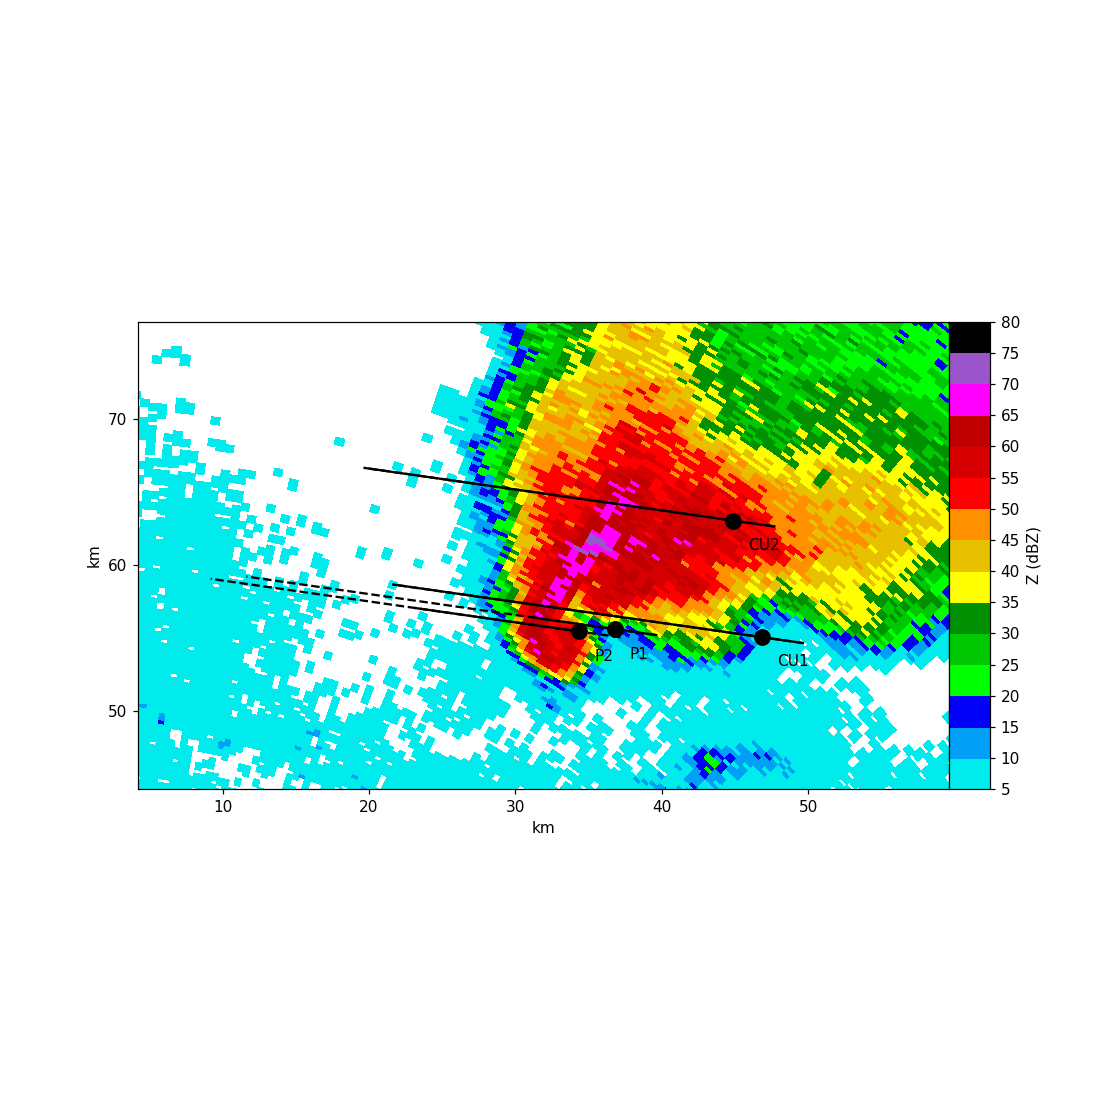

In [5]:
# Make a plot of the disdrometer transects through the storm, 
# choosing a representative sweeptime as the backdrop
plotdir = '/Users/dawson29/Projects/VORTEX2/model_DSD_study/pyPIPS_plots/'+casedate
sweeptimeref = radar_dict[casedate]['sweeptime_ref']
ustorm, vstorm = radar_dict[casedate]['feature_motion']
sweepindex = np.searchsorted(sweeptimelist, sweeptimeref)
sweepdtrel = [(sweeptime - sweeptimeref).total_seconds() for sweeptime in sweeptimelist]
deployed = dis_dict_at_radar[casedate]['convdata_at_sweeptimes']['deployed']
# dxsr = [[dx - ustorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dx, dp in zip(dxlist, deployed)]
# dysr = [[dy - vstorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dy, dp in zip(dylist, deployed)]
dxsr = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxlist]
dysr = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dylist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsr_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsr, deployed)]
dxsr_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsr, deployed)]
dysr_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysr, deployed)]
dysr_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysr, deployed)]

print sweeptimelist
print sweepindex
print deployed[0]
print dxsr[0]
print dxsr_d[0]
print dxsr_nd[0]

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.nanmin(np.array(dxsr))
Dxmax = np.nanmax(np.array(dxsr))
Dymin = np.nanmin(np.array(dysr))
Dymax = np.nanmax(np.array(dysr))
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]
# plotlims = [15000., 45000., -15000., 0.]

figlist, gridlist = radar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[sweepindex], ovrmap, 
                                              ovrdis, dis_name_list, dxy_list, fields_D_list)
ax = gridlist[0][0]

dis_names = dis_dict_at_radar[casedate]['dis_names']

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxlist)), dxsr, dysr, dxsr_d, dysr_d, 
                                                          dxsr_nd, dysr_nd, deployed, dis_names):
    ax.plot(dx_d, dy_d, ls='-', c='k')
    ax.plot(dx, dy, ls='--', c='k')
    if dp[sweepindex]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)

gridlist[0].cbar_axes[0].set_ylabel('Z (dBZ)')
ax.set_xlabel('km')
ax.set_ylabel('km')
    
figlist[0].canvas.draw()
figlist[0].set_size_inches(10., 10., forward = True)

figpath = os.path.join(plotdir, casedate+'_transects_radar.png')
plt.savefig(figpath, dpi=300)

Starting and ending grid coordinates are:
             igbgn = 0, igend = 400, jgbgn = 0, jgend = 400
[0.0 100.0 207.4962615966797 323.05072021484375 447.2674255371094
 580.7957153320312 724.3336791992188 878.6315307617188 1044.4959716796875
 1222.7940673828125 1414.4578857421875 1620.4892578125 1841.96533203125
 2080.043701171875 2335.968994140625 2611.079345703125 2906.8125
 3224.714599609375 3566.447509765625 3933.79736328125 4328.68505859375
 4753.17431640625 5209.484375 5700.00048828125 6200.00048828125
 6700.00048828125 7200.00048828125 7700.00048828125 8200.0009765625
 8700.0009765625 9200.0009765625 9700.0009765625 10200.0009765625
 10700.0009765625 11200.0009765625 11700.0009765625 12200.0009765625
 12700.0009765625 13200.0009765625 13700.0009765625 14200.0009765625
 14700.0009765625 15200.0009765625 15700.0009765625 16200.0009765625
 16700.0 17200.0 17700.0 18200.0 18700.0 19200.0 19700.0 20200.0 20700.0
 21200.0 21700.0 22200.0 22700.0 23200.0 23700.0 24200.0] [0.0 103.74813

<IPython.core.display.Javascript object>


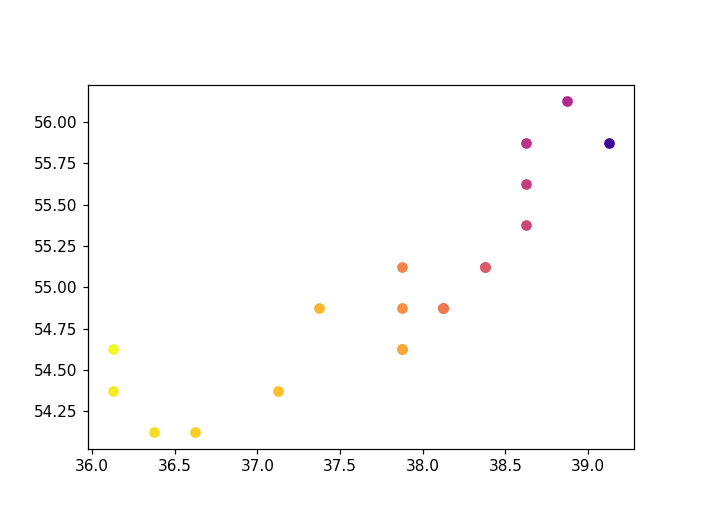

The model time is 7200 s
Deriving variable vortz
(50, 50)
max vortz at height z = 3000.0 m
is 0.02
The location is x,y = 44.12,55.88 (i,j = 176,223)
The model time is 7320 s
Deriving variable vortz
(26, 26)
max vortz at height z = 3000.0 m
is 0.03
The location is x,y = 41.12,55.62 (i,j = 164,222)
The model time is 7440 s
Deriving variable vortz
(26, 26)
max vortz at height z = 3000.0 m
is 0.05
The location is x,y = 39.88,55.62 (i,j = 159,222)
The model time is 7560 s
Deriving variable vortz
(26, 26)
max vortz at height z = 3000.0 m
is 0.05
The location is x,y = 39.12,55.88 (i,j = 156,223)
[36, 277, 103, 344, 0, 1]
[36, 278, 103, 345, 0, 1]
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.
['rhoscst', 'zh', 'zg', 'rhorcst', 'zr', 'zs', 'rhogc

['rhoscst', 'zh', 'zg', 'rhorcst', 'zr', 'zs', 'rhogcst', 'qgw', 'tair', 'rhohcst', 'qhw', 'rhos', 'rhor', 'nts', 'ntr', 'nth', 'rhoh', 'qsw', 'rhoa', 'rhog', 'ntg', 'alphar', 'alphas', 'qs', 'qr', 'alphag', 'qg', 'qh', 'alphah']
['rhoscst', 'zh', 'zg', 'rhorcst', 'qh', 'nth', 'zr', 'zs', 'rhogcst', 'qgw', 'PTE', 'tair', 'rhohcst', 'TH', 'VC', 'qhw', 'rhos', 'rhor', 'nts', 'ntr', 'P', 'rhoh', 'U', 'V', 'rhoa', 'rhog', 'ntg', 'alphar', 'alphas', 'qs', 'qr', 'QV', 'DBZ', 'alphag', 'qg', 'qsw', 'alphah', 'UC']
The model time is 9360 s
Deriving variable vortz
(26, 26)
max vortz at height z = 3000.0 m
is 0.05
The location is x,y = 38.12,54.88 (i,j = 152,219)
[32, 273, 99, 340, 0, 1]
[32, 274, 99, 341, 0, 1]
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter

Deriving variable vortz
(26, 26)
max vortz at height z = 3000.0 m
is 0.07
The location is x,y = 37.12,54.38 (i,j = 148,217)
[28, 269, 97, 338, 0, 1]
[28, 270, 97, 339, 0, 1]
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.
['rhoscst', 'zh', 'zg', 'rhorcst', 'zr', 'zs', 'rhogcst', 'qgw', 'tair', 'rhohcst', 'qhw', 'rhos', 'rhor', 'nts', 'ntr', 'nth', 'rhoh', 'qsw', 'rhoa', 'rhog', 'ntg', 'alphar', 'alphas', 'qs', 'qr', 'alphag', 'qg', 'qh', 'alphah']
['rhoscst', 'zh', 'zg', 'rhorcst', 'qh', 'nth', 'zr', 'zs', 'rhogcst', 'qgw', 'PTE', 'tair', 'rhohcst', 'TH', 'VC', 'qhw', 'rhos', 'rhor', 'nts', 'ntr', 'P', 'rhoh', 'U', 'V', 'rhoa', 'rhog', 'ntg', 'alphar', 'alphas', 'qs', 'qr', 'QV', 'DBZ', 'alphag', 'qg', 'qsw', 'alphah', 'UC']
The model time

In [45]:
# Set up stuff for time composites
# Initial grid limits (m)
gridlims = [0., 100000., 0., 100000.]

# Width of composite box in m
compositewidthx = 60000.
compositewidthy = 60000.

# Width of search box for extremum in m
searchboxwidthx = 6000.
searchboxwidthy = 6000.

# Name of variable for whose extrema to track for compositing (that's an awkward phrasing)
tracking_varname = 'vortz'
# level (height in m) at which to track the extrema
tracking_level = 3000.0 # 0.0 for 5 June, 3000.0 for 7 June, 3000.0 for 9 June 
# Type of extremum (max or min)
tracking_extremum = 'max'
# Threshold magnitude of extremum below which to throw out a time from the composite
tracking_thresh = 0.05

compositedict = {'gridlims': gridlims,
                 'compositewidth': (compositewidthx, compositewidthy), 
                 'searchboxwidth': (searchboxwidthx, searchboxwidthy),
                 'tracking_varname': tracking_varname,
                 'tracking_extremum': tracking_extremum, 
                 'tracking_level': tracking_level, 
                 'tracking_thresh': tracking_thresh}

# Read in the model information for the case we want
model_dict = sim.set_dh(casedate, init_model_dict, radar_dict)
dh = model_dict[casedate]['DataHandler']
modeltime_ref = model_dict[casedate]['modeltime_ref']

# Read in the model grid info
grid_dict = sim.read_model_grid(dh)
# Initialize composite parameters
if model_dict[casedate]['composite']:
    compositedict = sim.init_composite(compositedict, grid_dict)

# dp_data, consts = dh.loadMicrophysics()
# # Extract the lowest model level and store in dp_data_2D
# dp_data_2D = {}
# for key, dat in dp_data.iteritems():
#     dp_data_2D[key] = dat[:,:,0]
# dp_data_plot = {}
# for key, dat in dp_data_2D.iteritems():
#     dp_data_plot[key] = dat.swapaxes(0, 1).squeeze()
# dp_data_plot_list.append(dp_data_plot)

if model_dict[casedate]['composite']:
    print "Building composite!"
    varcompdict = sim.build_composite(casedate, model_dict, compositedict, dh)
    Zmod = varcompdict['DBZ']
    Zmodplot = Zmod
else:    
    Zmod = dh.loadModelReflectivity()
    Zmodplot = Zmod[:, :, 0].T
# Zmodplot_list.append(Zmodplot)

<IPython.core.display.Javascript object>


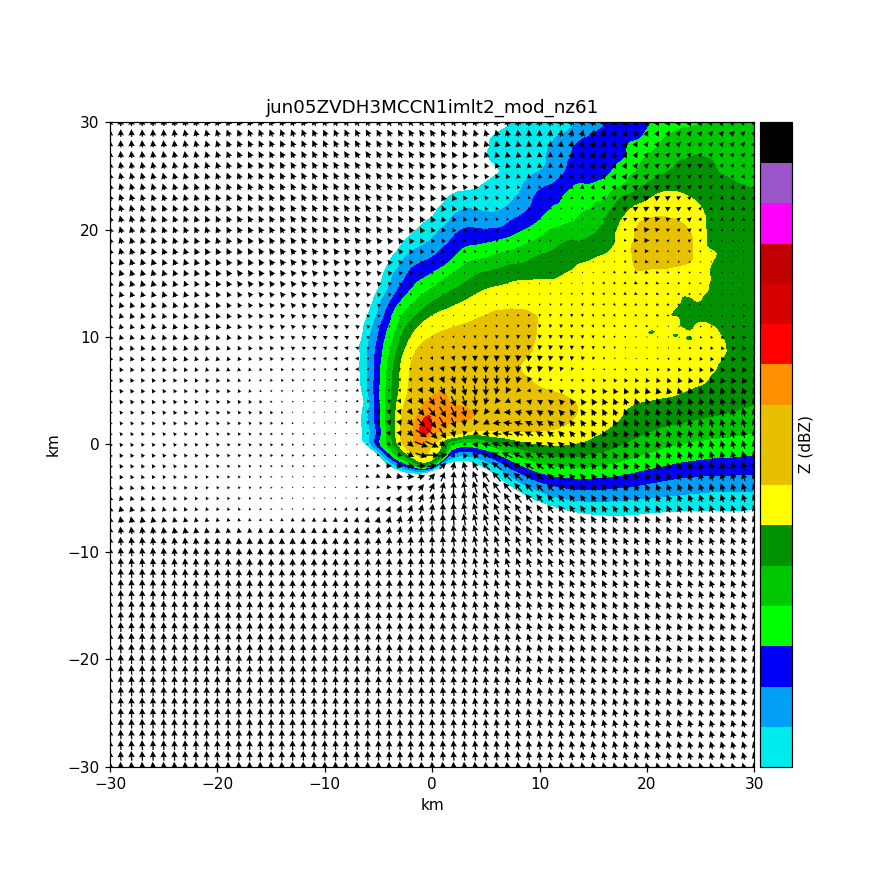

In [7]:
# Quick plot of the reflectivity composite for testing
runname = model_dict[casedate]['runname']
model_times = model_dict[casedate]['model_times']
xckm_comp, yckm_comp = compositedict['ccoords']
uccomp = varcompdict['UC']
vccomp = varcompdict['VC']
wind_pltscale = 2.0 # Scale of wind vectors
windintv = 4        # Interval in grid points to plot wind vectors

clevels = np.arange(0., 85., 5.)
cintv = clevels[1] - clevels[0]
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5., 5.)
cbarlevels = ticker.MultipleLocator(base=cintv)
clabel = 'Z (dBZ)'
# qrplot = varcompdict['qg']*1000.
# clevels = np.arange(0., 5.05, 0.05)
# cintv = clevels[1] - clevels[0]
# norm = None
# cmap = cm.Blues
# cbarlevels = np.arange(0., 5.5, 0.5) # ticker.MultipleLocator(base=1.0)
# clabel = 'qg (g/kg)'

compfig = plt.figure(figsize=(8,8))
compax = compfig.add_subplot(111)
plt.title(model_dict[casedate]['runname'])
dBZplt = compax.contourf(xckm_comp, yckm_comp, Zmodplot, levels=clevels, cmap=cmap)
# compax.contour(xskm_comp,yskm_comp,dBZ.T,levels=np.arange(30.,90.,10.),colors='k')
windplt = compax.quiver(xckm_comp[::windintv], yckm_comp[::windintv], uccomp[::windintv, ::windintv],
    vccomp[::windintv, ::windintv], pivot='middle', units='width', scale_units='width', 
    scale=1200.0/float(wind_pltscale), width=0.001*float(wind_pltscale), headwidth=5, headlength=5, color='k')

compax.set_aspect('equal')
divider = make_axes_locatable(compax)
cax = divider.append_axes("right", size="5%", pad = 0.05)
clabels = cbarlevels
clvllocator = ticker.FixedLocator(clabels)
plt.colorbar(dBZplt, ticks=clvllocator, cax=cax)
cax.set_ylabel('Z (dBZ)')
#cax.set_ylabel('qg (g/kg)')

compax.set_xlabel('km')
compax.set_ylabel('km')

compfig.savefig(runname+'_dBZ_comp_{:06d}_{:06d}.pdf'.format(int(model_times[0]),int(model_times[-1])),dpi=200)

<IPython.core.display.Javascript object>


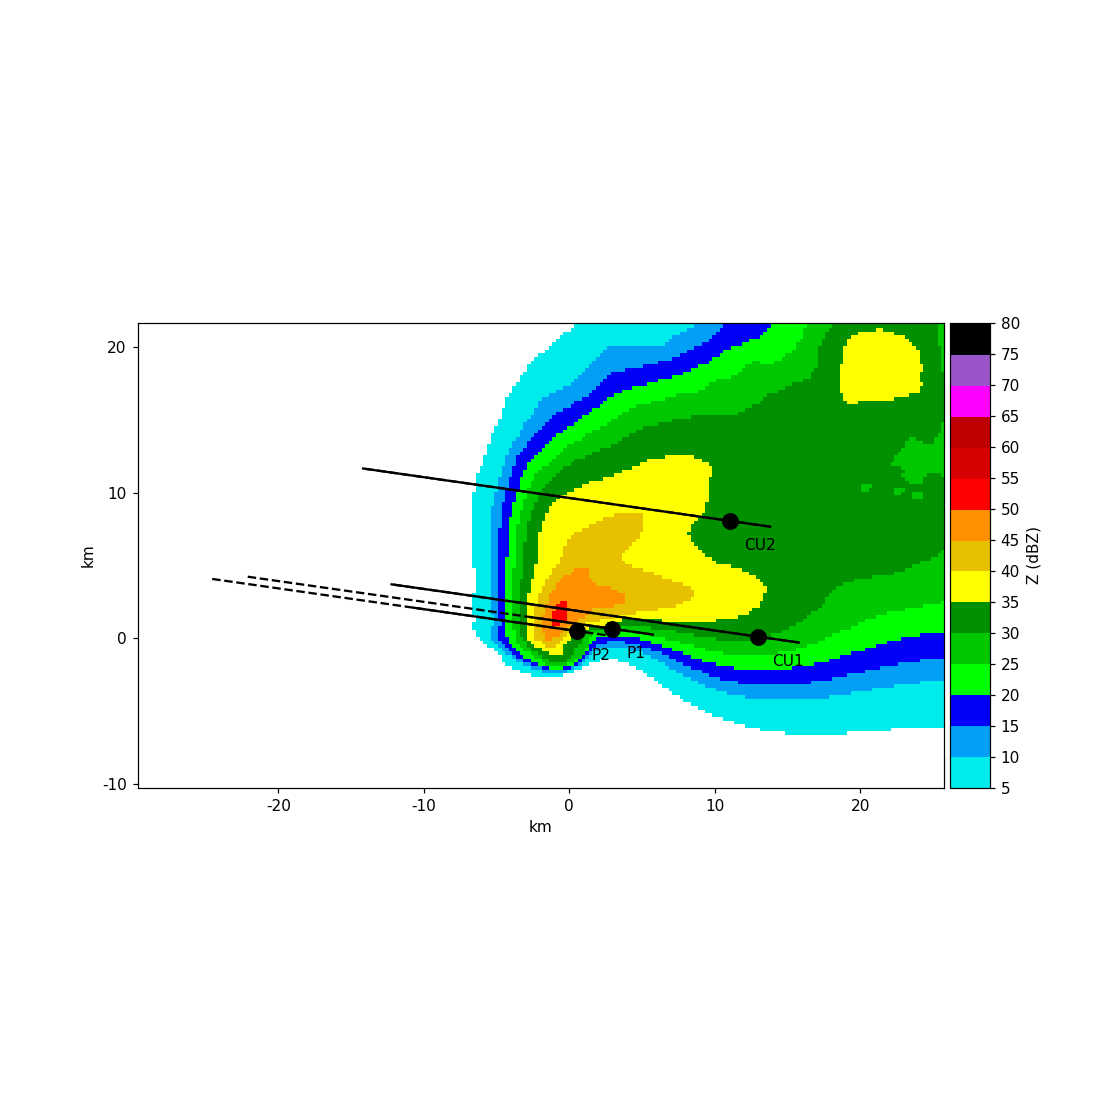

[-29695.9213401311, 25775.607369744364] [-10291.015904083371, 21674.294729292433]
10000.0 10000.0


In [8]:
# Make a plot of the disdrometer transects through the *simulated* storm, 
# choosing a representative *model time* as the backdrop

# First we need to set up a list of x and y coordinates within the model for each disdrometer. We'll use the
# coordinates computed relative to the radar above, but shifted so that they are in the same relative position
# to the model storm (necessarily subjective) as they are for the observed storm.
# For example, we'll use P2's coordinates near the tip of the hook for 5 June 2009.

if model_dict[casedate]['composite']:
    xref_model, yref_model = model_dict[casedate]['ref_coords_comp']
    # Some coordinate array shenanigans
    composite_grid_dict = sim.get_composite_grid(grid_dict, compositedict)
    xcplot = composite_grid_dict['xcplot']
    ycplot = composite_grid_dict['ycplot']
    xeplot = composite_grid_dict['xeplot']
    yeplot = composite_grid_dict['yeplot']
    xcorplot = composite_grid_dict['xcorplot']
    ycorplot = composite_grid_dict['ycorplot']
else:
    xref_model, yref_model = model_dict[casedate]['ref_coords']
    xcplot = grid_dict['xcplot']
    ycplot = grid_dict['ycplot']
    xeplot = grid_dict['xeplot']
    yeplot = grid_dict['yeplot']
    xcorplot = grid_dict['xcorplot']
    ycorplot = grid_dict['ycorplot']

xref_rad = dxlist[-1]
yref_rad = dylist[-1]

xshift = xref_model - xref_rad
yshift = yref_model - yref_rad

dxmodlist = [dx + xshift for dx in dxlist]
dymodlist = [dy + yshift for dy in dylist]

# Using sweeptimelist here to facilitate matching with the disdrometer locations on the radar plot.
sweepdtrel = [(sweeptime - modeltime_ref).total_seconds() for sweeptime in sweeptimelist]
dxsrm = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxmodlist]
dysrm = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dymodlist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsrm_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsrm, deployed)]
dxsrm_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsrm, deployed)]
dysrm_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysrm, deployed)]
dysrm_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysrm, deployed)]

# Get the index where the relative time is zero. Use this below to put the probes
# at the proper location along the transect corresponding to the reference time.
modelindex_ref = np.searchsorted(sweepdtrel, 0.)

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.array(dxsrm).min()
Dxmax = np.array(dxsrm).max()
Dymin = np.array(dysrm).min()
Dymax = np.array(dysrm).max()
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]

fig = None
ax = None
ptype = 2
xlim = [plotlims[0], plotlims[1]]
ylim = [plotlims[2], plotlims[3]]
clevels = np.arange(0., 85., 5.)
cintv = clevels[1] - clevels[0]
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5., 5.)
cbarlevels = ticker.MultipleLocator(base=cintv)
clabel = 'Z (dBZ)'
cformat = None
ovrmap = False
gis_info = None
numovr = 0
axesticks = [10000., 10000.]

fig, ax = pm.plotsingle(fig, ax, ptype, xcplot, ycplot, xcorplot, ycorplot, xlim, ylim, Zmodplot, clevels, cmap, norm,
                            cbarlevels, clabel, cformat, ovrmap, gis_info, numovr, None, None, None, None, None,
                            axesticks)

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxmodlist)), dxsrm, dysrm, dxsrm_d, dysrm_d, 
                                                          dxsrm_nd, dysrm_nd, deployed, dis_names):
    ax.plot(dx, dy, ls='--', c='k')
    ax.plot(dx_d, dy_d, ls='-', c='k')
    if dp[modelindex_ref]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)
    
fig.canvas.draw()
fig.set_size_inches(10., 10., forward = True)
figpath = os.path.join(plotdir, casedate+'_transects_model.png')
plt.savefig(figpath, dpi=300)

In [9]:
# Read in time series and add to dis_dict
dis_dict = sim.read_probe_time_series(casedate, dis_dict, radar_dict)


Requested DSD interval: 60.0. Actual DSD interval: 60.0
Requested DSD interval: 60.0. Actual DSD interval: 60.0
Requested DSD interval: 60.0. Actual DSD interval: 60.0
Requested DSD interval: 60.0. Actual DSD interval: 60.0


In [15]:
if not model_dict[casedate]['composite']:
    varlists = ['DBZ', 'TH', 'QV', 'P']
    varlistv = ['U', 'V']
    varlist_derived = ['PTE', 'UC', 'VC']

    vardictlist = sim.read_vardict(casedate, model_dict, varlists, varlistv, varlist_derived)

    vardict = vardictlist[0]
    grid_dict_in = grid_dict
else:
    vardict = varcompdict
    grid_dict_in = composite_grid_dict

# Find grid intersections
dis_ts_model_dict = sim.find_transect_grid_intersections(casedate, grid_dict_in, dis_dict, model_dict, radar_dict, 
                                     vardict, plot_locations=False, debug=False)

In [16]:
print dis_dict[casedate].keys()
print dis_ts_model_dict.keys()
print varcompdict['rhoa']
dis_ts_vars_points = dis_ts_model_dict['dis_ts_vars_points']
print len(dis_ts_vars_points)
dis_names = dis_dict[casedate]['dis_names']
print len(dis_names)

['dis_names', 'dradloclist', 'starttimes', 'timeseries', 'dis_dir', 'convdata_at_sweeptimes', 'stoptimes', 'dis_types', 'disfilenames', 'dgeoloclist', 'convfilenames']
['dis_ts_stimes', 'dis_ts_vars', 'dis_ts_vars_points', 'dis_ts_ijlocs', 'dis_ts_times', 'dis_ts_xyslocs', 'dis_ts_tlocs', 'dis_ts_xylocs']
[[0.96461405 0.96461444 0.96461437 ... 0.9646478  0.96464847 0.96464914]
 [0.96461446 0.964615   0.9646151  ... 0.96464801 0.96464866 0.9646493 ]
 [0.96461499 0.96461561 0.96461576 ... 0.96464819 0.96464884 0.96464952]
 ...
 [0.96637816 0.96637432 0.96632124 ... 0.96541408 0.96541014 0.96538869]
 [0.96642355 0.96643087 0.96634762 ... 0.9654087  0.96538817 0.9653832 ]
 [0.96632522 0.96634    0.96629817 ... 0.96546389 0.96539398 0.96539031]]
4
4


/Users/dawson29/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


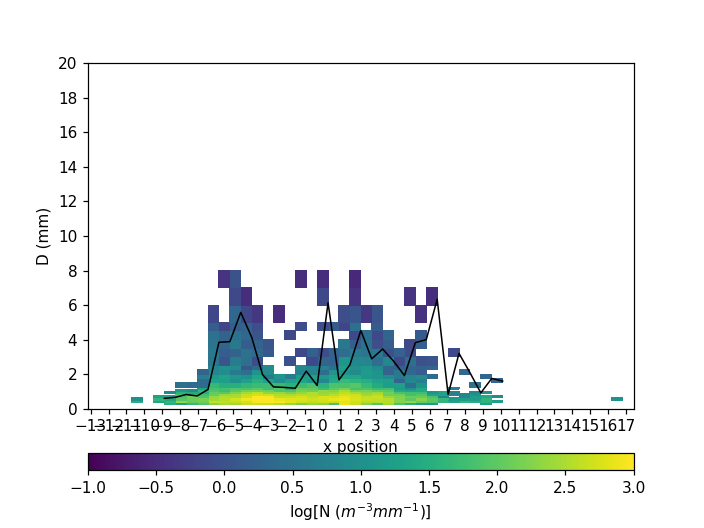

<IPython.core.display.Javascript object>


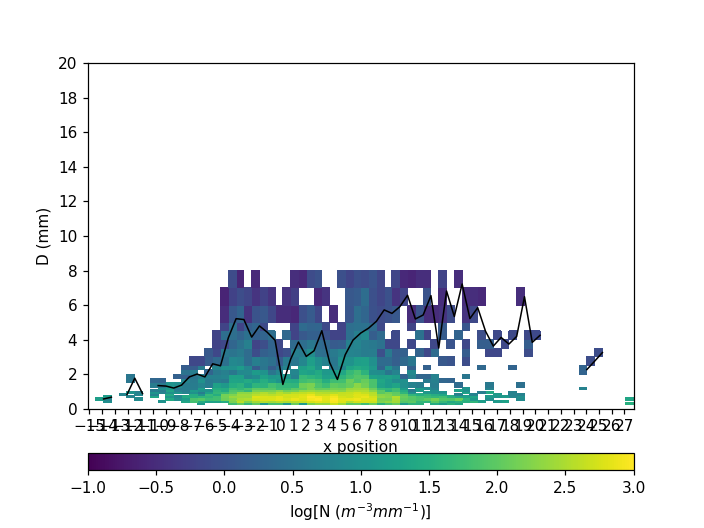

<IPython.core.display.Javascript object>


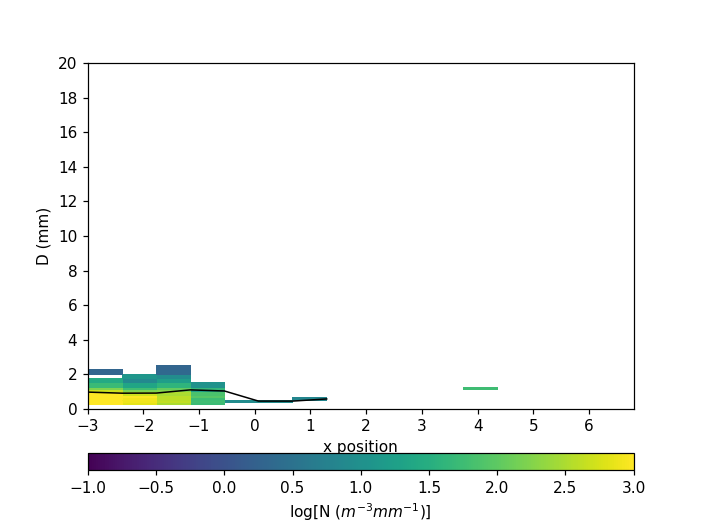

<IPython.core.display.Javascript object>


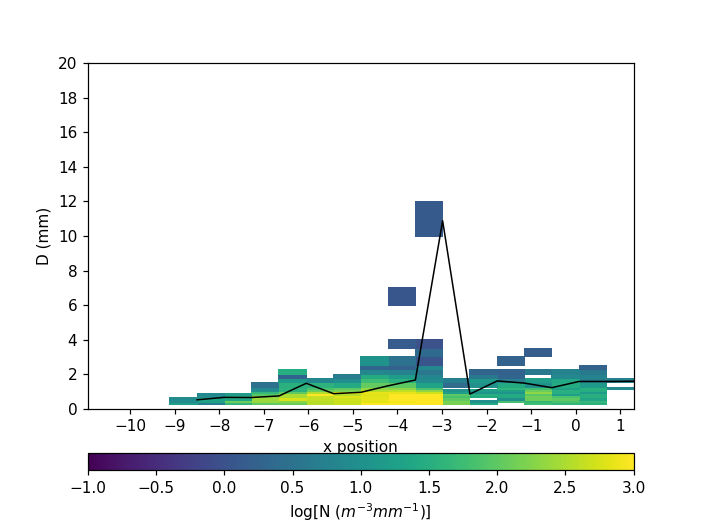

In [41]:
# Now plot the observed DSD transects

bin_width = Dr - Dl

D0r_obs = []
for d, dis_name in enumerate(dis_dict[casedate]['dis_names']):
    sample_xlocs = np.array([xylocs[0] for xylocs in dis_ts_model_dict['dis_ts_xyslocs'][d]])
    Nc_bin = dis_dict[casedate]['timeseries']['ND'][d]
    logNc_bin = np.log10(Nc_bin)
    logNc_bin = np.ma.masked_where(logNc_bin <= -1.0, logNc_bin)
    D0r = np.zeros((np.size(np.array(sample_xlocs))))
    # Calculate median drop diameter
    for t in xrange(sample_xlocs.size):
        D0r[t] = dis.calc_D0_bin(D, Dl, Dr, Nc_bin[t, :], bin_width)
    plotparamdicts = [{'type': 'pcolor', 'vlimits': (-1.0, 3.0), 'clabel': r'log[N ($m^{-3} mm^{-1}$)]'}]
    xvals = [sample_xlocs/1000.]
#     print "xvals = ", xvals
    yvals = [Dl*1000.]
    zvals = [logNc_bin.T]
    ax = pm.plotmeteogram(None, xvals, zvals, plotparamdicts, yvals=yvals)
    axparamdicts = [{'majorxlocator': ticker.MultipleLocator(base=1.0), 
                     'majorylocator': ticker.MultipleLocator(base=2.0),
                     'axeslimits': [None, (0.0, 20.0)],
                     'axeslabels': ['x position', 'D (mm)']}]
    axlist = pm.set_meteogram_axes([ax], axparamdicts)
    ax.plot(xvals[0], D0r*1000., c='k', ls='-', lw=1)
    D0r_obs.append(D0r)

D0r =  [       nan 0.0038915  0.00392838 0.0039411  0.0039296  0.00389389
 0.00383643 0.00377136 0.00369464 0.00361524 0.00352507 0.00342254
 0.00332985 0.00323419 0.00312112 0.00300672 0.00290808 0.00277006
 0.00268073 0.00260564 0.00254007 0.0025119  0.00251357 0.00259724
 0.00259395 0.0025815  0.0025795  0.00259852 0.00264411 0.00284309
 0.00318811 0.00333422 0.00314365 0.0028295  0.00253541 0.00215501
 0.00175617 0.00144094 0.00116392 0.00093617 0.00078056 0.00067585
 0.00059808 0.00053524 0.00051872 0.00048173 0.00046186 0.00046058
 0.00045936 0.00044736 0.00044861]
D0r (sampled) =  [0.001625          nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.002125   0.001625
        nan 0.002375          nan 0.00425    0.00135014 0.00349869
 0.00255775        nan 0.00417453 0.00212669 0.00201276 0.00222886
 0.00418675 0.00198984 0.00247738 0.0032524  0.0031855  0.00284355
 0.00316202 0.0029039  0.00324748 0.00276248 0.00278994 0.00220453
 0.00

/Users/dawson29/pyPIPS/modules/simulator.py:1420: RuntimeWarning: divide by zero encountered in log10
  logNc_bin = np.log10(Nc_bin)
/Users/dawson29/pyPIPS/modules/simulator.py:1425: RuntimeWarning: divide by zero encountered in log10
  logNc_bin_ps = np.log10(Nc_bin_ps)


<IPython.core.display.Javascript object>


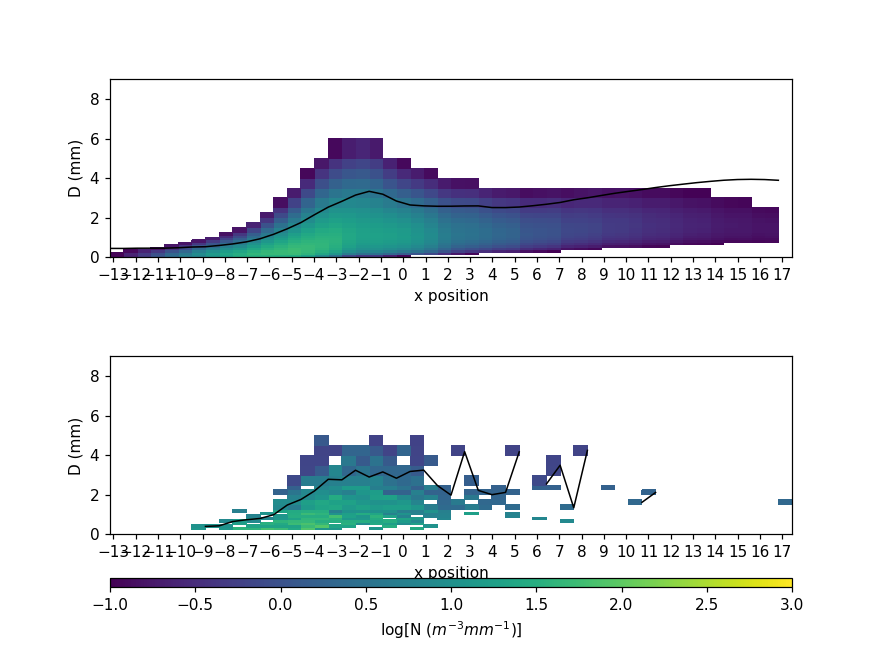

D0r =  [       nan 0.00247641 0.00252411 0.00256355 0.00259502 0.00261095
 0.00261085 0.00263277 0.0026575  0.0026626  0.00270106 0.00272844
 0.00273124 0.00275863 0.00275956 0.00274566 0.0027645  0.00276093
 0.00275495 0.00276191 0.00273762 0.00272925 0.00274615 0.00270964
 0.00273792 0.00279416 0.00278469 0.0028216  0.00283893 0.00277722
 0.0027959  0.00281776 0.00280401 0.00280145 0.00278288 0.00277774
 0.00280459 0.00277334 0.0027434  0.00274517 0.00268203 0.00262923
 0.00258055 0.00247421 0.0023972  0.00233162 0.00221079 0.00212474
 0.00201011 0.00185541 0.0017462  0.00162637 0.00146657 0.00134024
 0.00121332 0.00104878 0.00096626 0.00085441 0.00074501 0.00068249
 0.0005852  0.00056338 0.000492   0.00045359 0.00039945 0.00038554
 0.00034841 0.0003261  0.00031085 0.0002845         nan]
D0r (sampled) =  [0.00254868 0.00222728 0.00266497 0.00222999 0.00319498 0.00211533
 0.00500916 0.00240647 0.00297848 0.00240787 0.00260218 0.00222711
 0.00281232 0.00331417 0.00252315 0.00284307 0.0

/Users/dawson29/pyPIPS/modules/simulator.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1. / lamda


<IPython.core.display.Javascript object>


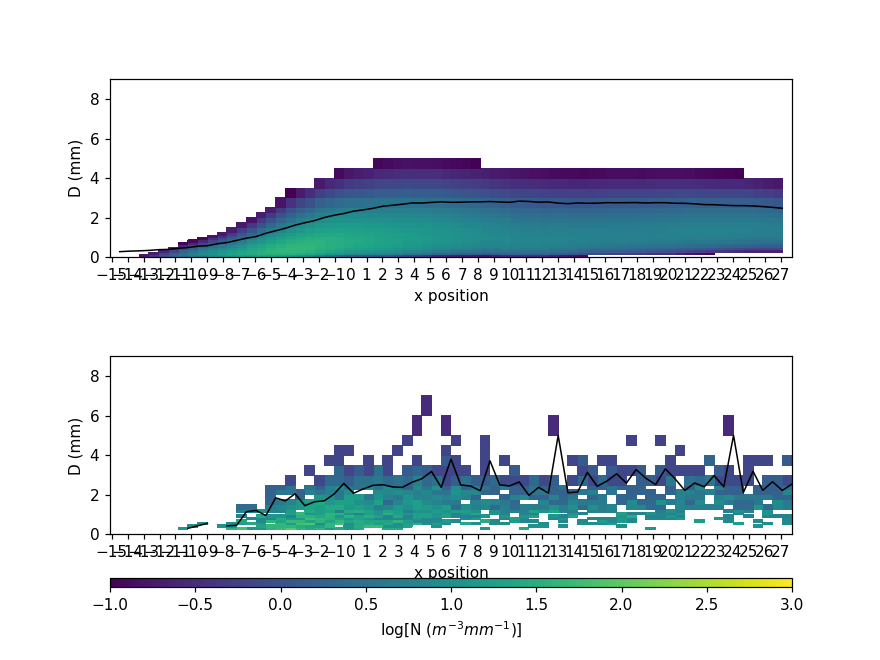

D0r =  [       nan 0.00286772 0.00279161 0.00273295 0.00261523 0.00259946
 0.0024656  0.00247436 0.0024345  0.00235753 0.00233583 0.00257101
 0.00301066 0.00336255 0.00332061 0.00305568 0.00275429]
D0r (sampled) =  [       nan        nan        nan        nan 0.001625          nan
 0.001875   0.00138182 0.00232979 0.00402459 0.00312675 0.00282989
 0.00285021 0.00366727 0.00331173 0.00295408 0.00332013]


<IPython.core.display.Javascript object>


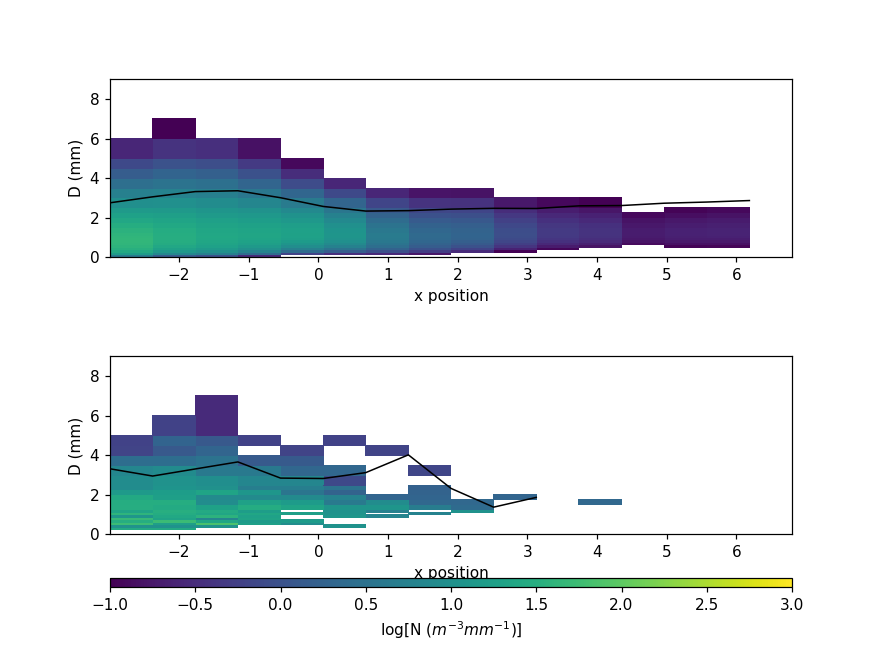

D0r =  [       nan 0.00276129 0.00279234 0.00312567 0.00339757 0.00326305
 0.00304327 0.00270699 0.00228496 0.00186065 0.00143195 0.00117429
 0.00106809 0.0009623  0.00086997 0.00081253 0.00078987 0.00081942
 0.00076643 0.00074673 0.00068721]
D0r (sampled) =  [0.00319809 0.00279078 0.00283085 0.00287644 0.0029565  0.0028935
 0.00280527 0.00266985 0.00276046 0.00167208 0.00148646 0.00114245
 0.00104583 0.00070276 0.00088031 0.00075146 0.0004375         nan
 0.0011875         nan        nan]


<IPython.core.display.Javascript object>


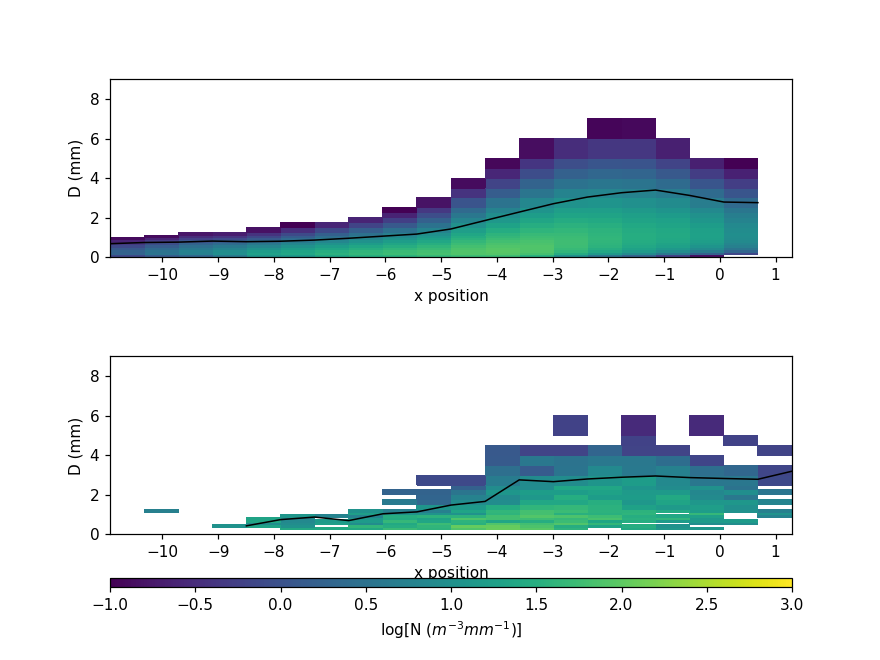

In [40]:
transect_DSD_dict = sim.interp_model_to_transect(casedate, dis_dict, model_dict, dis_ts_model_dict,
                                                 sampling_interval=60., add_hail=False, 
                                                 use_bins_for_interp=True, use_Parsivel_simulator=True, 
                                                 Dmax=9.0, plot_transects=True)

<IPython.core.display.Javascript object>


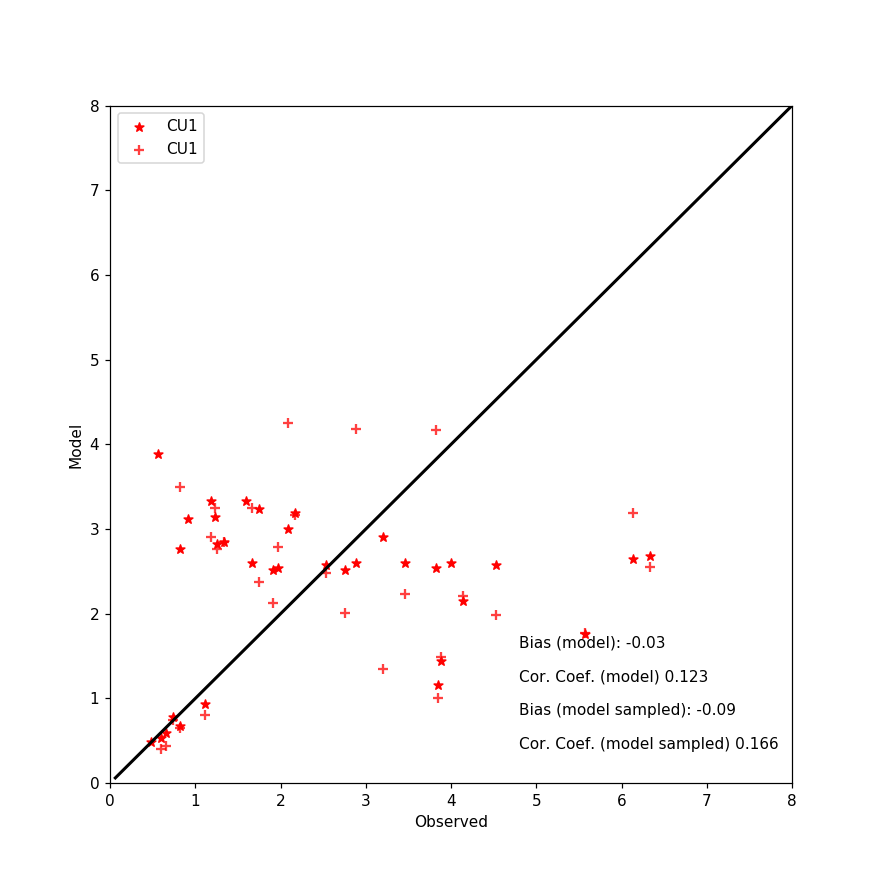

<IPython.core.display.Javascript object>


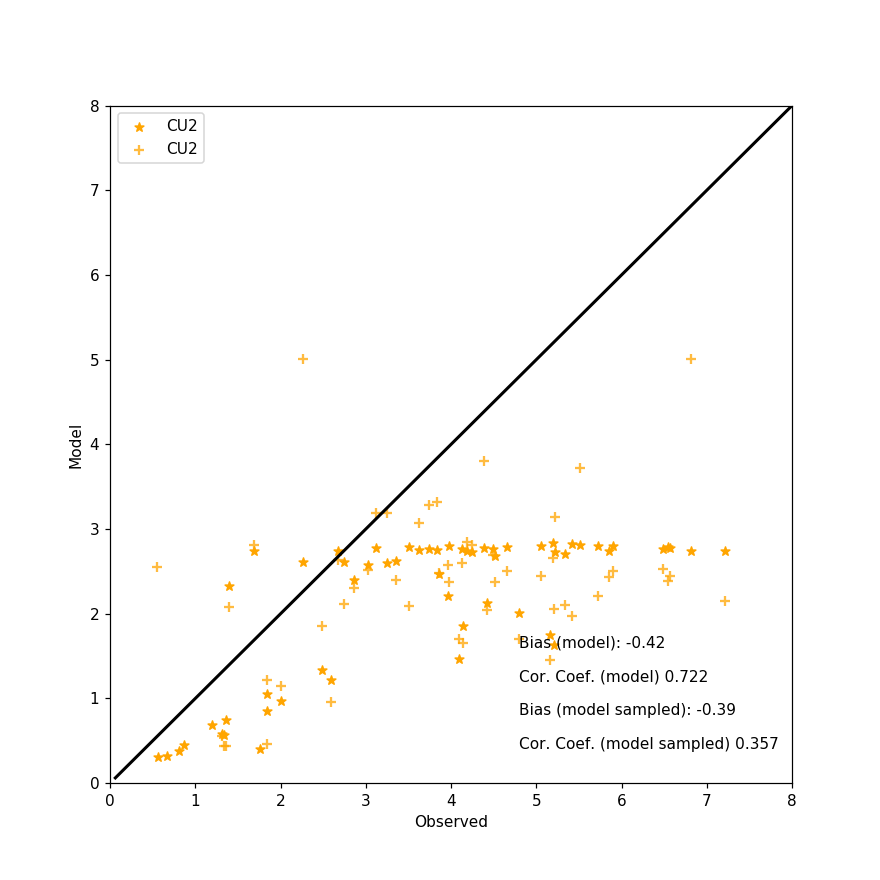

<IPython.core.display.Javascript object>


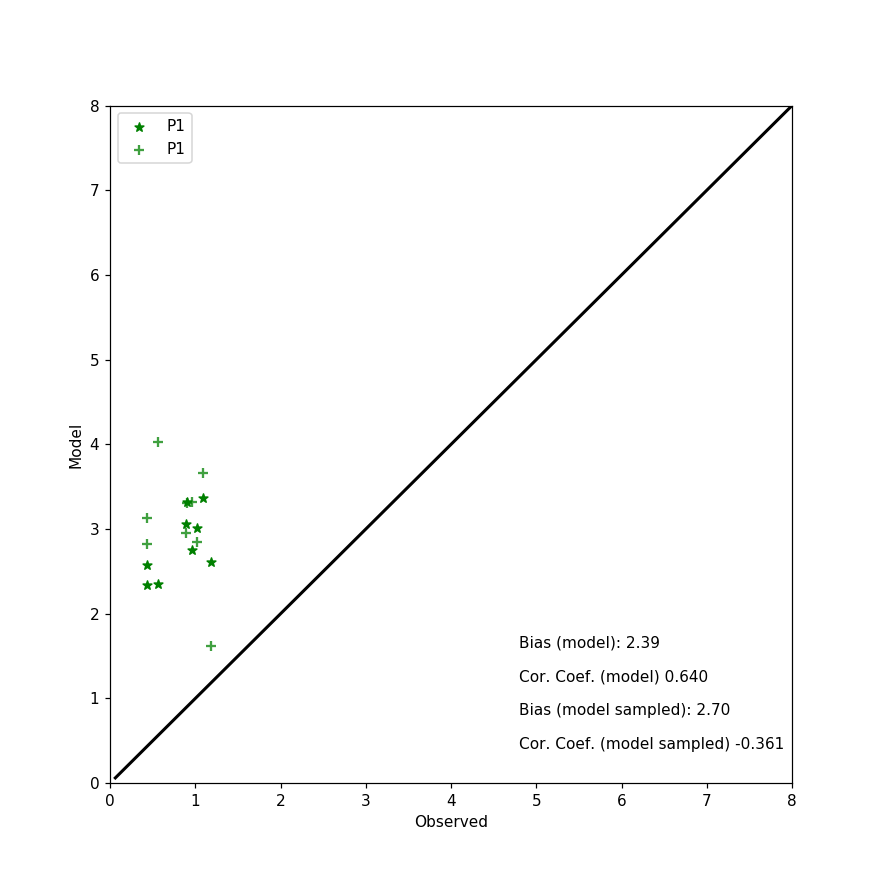

<IPython.core.display.Javascript object>


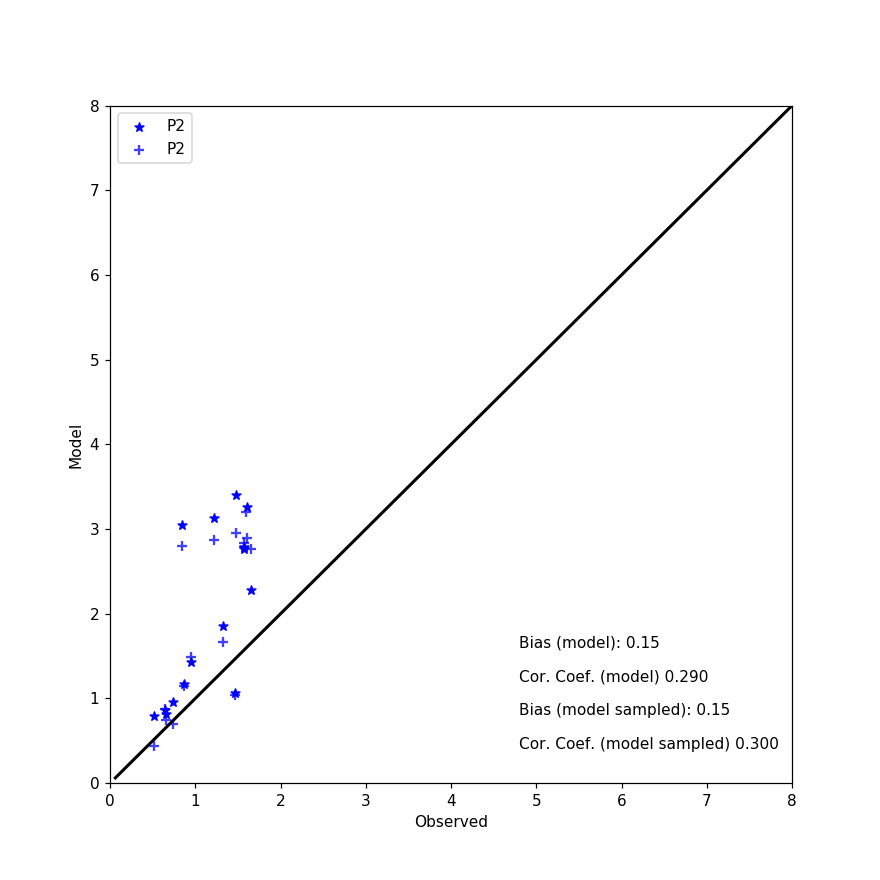

In [44]:
# Make some one-to-one plots of D0 (model) vs. D0 (disdrometer)

yvals = D*1000.
xvals = D*1000.
color_list = ['r', 'orange', 'g', 'b']

D0r_mod = transect_DSD_dict['D0r']
D0r_mod_sampled = transect_DSD_dict['D0r_ps']

for d, dis_name in enumerate(dis_dict[casedate]['dis_names']):
    obs = D0r_obs[d]*1000.
    mod = D0r_mod[d]*1000.
    mod_sampled = D0r_mod_sampled[d]*1000.
    bias_mod = ((np.nansum(mod-obs))/np.nansum(obs))
    bias_mod_sampled = ((np.nansum(mod_sampled-obs))/np.nansum(obs))
    cc_mod = pd.DataFrame({'obs': obs, 'mod': mod}).corr().iloc[0, 1]
    cc_mod_sampled = pd.DataFrame({'obs': obs, 'mod': mod_sampled}).corr().iloc[0, 1]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.scatter(obs, mod, c=color_list[d], marker='*', label=dis_name)
    plt.scatter(obs, mod_sampled, c=color_list[d], marker='+', alpha=0.75, label=dis_name)
    ax.plot(xvals, yvals, lw=2, color='k')
    ax.set_xlim(0.0, 8.0)
    ax.set_ylim(0.0, 8.0)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Model')
    ax.text(0.6, 0.20, 'Bias (model): {:2.2f}'.format(bias_mod), transform=ax.transAxes)
    ax.text(0.6, 0.15, 'Cor. Coef. (model) {:2.3f}'.format(cc_mod), transform=ax.transAxes)
    ax.text(0.6, 0.10, 'Bias (model sampled): {:2.2f}'.format(bias_mod_sampled), transform=ax.transAxes)
    ax.text(0.6, 0.05, 'Cor. Coef. (model sampled) {:2.3f}'.format(cc_mod_sampled), transform=ax.transAxes)
    plt.legend(loc='upper left')